# Project -- Analysing IRA tweets --

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import re
import string
import matplotlib.pyplot as plt
import glob
import spacy
import findspark
import nltk
import nltk.classify.util
from nltk.corpus import names
from urllib.parse import urlparse
import requests
import os, requests, uuid, json
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
# from unshortenit import UnshortenIt
 
findspark.init()

from pyspark import SparkContext

from pyspark.sql import *
from pyspark.sql.functions import to_timestamp, isnan
from pyspark.mllib.stat import Statistics
from pyspark.sql.functions import explode
from pyspark.sql.functions import col, when, length

import warnings # comment if you want to get the warnings from Searborn... ;) 
warnings.filterwarnings("ignore")
%matplotlib inline

spark = SparkSession.builder.getOrCreate()

C:\Users\TheMoums\Anaconda3\envs\ada\lib\importlib\_bootstrap.py:219: RuntimeWarning: cymem.cymem.Pool size changed, may indicate binary incompatibility. Expected 48 from C header, got 64 from PyObject
  return f(*args, **kwds)
C:\Users\TheMoums\Anaconda3\envs\ada\lib\importlib\_bootstrap.py:219: RuntimeWarning: cymem.cymem.Address size changed, may indicate binary incompatibility. Expected 24 from C header, got 40 from PyObject
  return f(*args, **kwds)


In [2]:
# set up data directory
DATA_DIR = 'data/'

There are two main parts in this current *Jupyter Notebook* :

* 1) **GETTING TO KNOW OUR MAIN DATASETS**. We intend to understand what contain our datasets (features and their dtypes) and to clean them in order to be ready for interpretation. We also may want to split or create new sub-datasets if there are interesting opportunities to do so.


* 2) **DESCRIPTIVE STATISTICS AND PROJECT FEASABILITY**. In this part of the notebook we want to give summary statistics about the datasets we will need the most for our project. Furthermore we will try to figure out whether or not our objectives of Milestone 1 are still feasible after the reading of our datasets. 

## 1. GETTING TO KNOW OUR MAIN DATASETS

### loading the data

In [3]:
# taking IRAN tweets into account or not 
include_iran = False

In [4]:
# load datasets thanks to Spark CSV reader 

if include_iran:
    
    # combine both RUS and IRAN datasets
    include_description = 'RUS & IRAN'
    
    tweets_text_df = spark.read.format("csv").option("header", "true").load(DATA_DIR+'*_troll_tweet_text.csv')
    tweets_stats_df = spark.read.format("csv").option("header", "true").load(DATA_DIR+'*_troll_tweet_stats.csv')
    tweets_meta_df = spark.read.format("csv").option("header", "true").load(DATA_DIR+'*_troll_tweet_metadata.csv')
    tweets_user_df = spark.read.format("csv").option("header", "true").load(DATA_DIR+'*_troll_user.csv')

else:
    
    # take only RUS datasets
    include_description = 'RUS'
    
    tweets_text_df = spark.read.format("csv").option("header", "true").load(DATA_DIR+'rus_troll_tweet_text.csv')
    tweets_stats_df = spark.read.format("csv").option("header", "true").load(DATA_DIR+'rus_troll_tweet_stats.csv')
    tweets_meta_df = spark.read.format("csv").option("header", "true").load(DATA_DIR+'rus_troll_tweet_metadata.csv')
    tweets_user_df = spark.read.format("csv").option("header", "true").load(DATA_DIR+'rus_troll_user.csv')

In [5]:
# look at the raw global datasets' sizes 

# n : number of observations
n_text = tweets_text_df.count()
n_stats = tweets_stats_df.count()
n_metadata = tweets_meta_df.count()
n_users = tweets_user_df.count()

# d : dimensionality of the data 
d_text = len(tweets_text_df.columns)
d_stats = len(tweets_stats_df.columns)
d_metadata = len(tweets_meta_df.columns)
d_users =  len(tweets_user_df.columns)

# print the results 
print(' Sizes of the datasets : ('+include_description+')')
print(' --------------------------------------------------------')
print('size of troll_tweet_text : '+str((n_text,d_text)))
print('size of troll_tweet_stats : '+str((n_stats,d_stats)))
print('size of troll_tweet_metadata : '+str((n_metadata,d_metadata)))
print('size of troll_user : '+str((n_users,d_users)))

 Sizes of the datasets : (RUS)
 --------------------------------------------------------
size of troll_tweet_text : (9041308, 3)
size of troll_tweet_stats : (9041308, 17)
size of troll_tweet_metadata : (9041308, 6)
size of troll_user : (3667, 11)


Roughly more than 9M tweets are available from RUS datasets (10M when combining both RUS AND IRAN). If after the cleaning there remains such a large number of data points, it's most likely that our statistical tests will present some significance if there are really underlying correlations, differences ... etc. 

We can assume, since the number of records for each dataframe is the same and because of the '*a priori*' description of the data, that the rows are ordered in such a way that every tuple of index $i$ in '*troll_tweet_text*' corresponds to the observations at index $i$ for '*troll_tweet_stats*' and '*troll_tweet_metadata*'. 

### tweets_text

In [6]:
# what does tweets_text look like ? size, dtypes
print((n_text,d_text))
tweets_text_df.dtypes

(9041308, 3)


[('tweetid', 'string'), ('tweet_language', 'string'), ('tweet_text', 'string')]

In [7]:
# a quick view
tweets_text_df.show(10)

+------------------+--------------+--------------------+
|           tweetid|tweet_language|          tweet_text|
+------------------+--------------+--------------------+
|877919995476496385|            ru|"RT @ruopentwit: ...|
|492388766930444288|            ru|Серебром отколоко...|
|719455077589721089|            bg|@kpru С-300 в Ира...|
|536179342423105537|            ru|Предлагаю судить ...|
|841410788409630720|            bg|Предостережение а...|
|834365760776630272|            ru|Двойная утопия, и...|
|577490527299457024|            ru|RT @harkovnews: Н...|
|596522755379560448|            ru|RT @NovostiNsk: «...|
|567357519547207680|            en|As sun and cloud ...|
|665533117369876480|            ru|RT @vesti_news: Ш...|
+------------------+--------------+--------------------+
only showing top 10 rows



***Is there anything to clean at this stage (before playing/dealing with the data) ?*** 

Below are listed the interventions we needed to perform in order to clean the data :      

Unknown *tweet_language* can take both the value 'und', or null. We harmonize this column by setting all NaN to 'und'.

In [8]:
tweets_text_df = tweets_text_df.fillna('und',['tweet_language'])

### tweets_stats

In [53]:
# what does tweets_stats look like ? size, dtypes
print((n_stats,d_stats))
tweets_stats_df.dtypes

(9041308, 17)


[('tweetid', 'string'),
 ('userid', 'string'),
 ('tweet_time', 'string'),
 ('in_reply_to_tweetid', 'string'),
 ('in_reply_to_userid', 'string'),
 ('quoted_tweet_tweetid', 'string'),
 ('is_retweet', 'string'),
 ('retweet_userid', 'string'),
 ('retweet_tweetid', 'string'),
 ('quote_count', 'string'),
 ('reply_count', 'string'),
 ('like_count', 'string'),
 ('retweet_count', 'string'),
 ('hashtags', 'string'),
 ('urls', 'string'),
 ('user_mentions', 'string'),
 ('poll_choices', 'string')]

***Is there anything to clean at this stage (before playing/dealing with the data) ?*** 

Below are listed the interventions we needed to perform in order to clean the data :      

We first convert the *tweet_time* into Datetime for ease of use, and we cast some columns into integers. We also create a static sql view of the main dataframe on which we can apply our SQL queries.

In [54]:
# dtypes transformations : 
tweets_stats_df = tweets_stats_df.withColumn('tweet_time', to_timestamp(tweets_stats_df.tweet_time))
tweets_stats_df = tweets_stats_df.withColumn('quote_count', tweets_stats_df.quote_count.cast('int'))
tweets_stats_df = tweets_stats_df.withColumn('reply_count', tweets_stats_df.reply_count.cast('int'))
tweets_stats_df = tweets_stats_df.withColumn('like_count', tweets_stats_df.like_count.cast('int'))
tweets_stats_df = tweets_stats_df.withColumn('retweet_count', tweets_stats_df.retweet_count.cast('int'))

# create a temporary Spark SQL view
tweets_stats_df.createOrReplaceTempView("tweets_stats_sql")

Now we can start splitting the data into smaller dataframes and remove the useless columns for each of those:
* **retweets_df** contains all the posts that are retweets.
* **replies_df** contains all the posts that are replies to other tweets.
* **normal_tweets_df** contains all the other ('normal') posts.

**NB:** some tweets have a value for *in_reply_to_userid* while their *in_reply_to_tweetid* is null (however the inverse never happens). Those are either replies to deleted tweets, or mentions of other users that were treated as replies. We decided to consider them as normal tweets.

In [55]:
# RETWEETS
retweets_df = spark.sql("SELECT * FROM tweets_stats_sql WHERE is_retweet=True")

# to understand how we selected the columns to remove, uncomment the next two lines
# => unique values for the whole column (either null, True , 0 ...)
#for col in retweets_df:
    #retweets_df.select(col).distinct().show(10)

# drop certain features
retweets_df = retweets_df.drop('in_reply_to_tweetid', 'in_reply_to_userid', 'is_retweet',\
                               'quote_count', 'reply_count', 'like_count', 'retweet_count',\
                               'poll_choices')

# record the size of the created sub-dataset
n_retweets = retweets_df.count()
d_retweets = len(retweets_df.columns)

# print the results
print(' Size of the sub-dataset : ('+include_description+')')
print(' --------------------------------------------------------')
print('size of retweets : '+str((n_retweets,d_retweets)))


 Size of the sub-dataset : (RUS)
 --------------------------------------------------------
size of retweets : (3333184, 9)


In [56]:
# REPLIES
replies_df = spark.sql("SELECT * FROM tweets_stats_sql WHERE is_retweet=False AND in_reply_to_tweetid IS NOT NULL")

# to understand how we selected the columns to remove, uncomment the next two lines
# => unique values for the whole column (either null, True , 0 ...)
#for col in replies_df:
    #replies_df.select(col).distinct().show(10)

# record the size of the created sub-dataset
replies_df = replies_df.drop('retweet_tweetid', 'retweet_userid', 'is_retweet')

# record the size of the created sub-dataset
n_replies = replies_df.count()
d_replies = len(replies_df.columns)

# print the results
print(' Size of the sub-dataset : ('+include_description+')')
print(' --------------------------------------------------------')
print('size of replies : '+str((n_replies,d_replies)))

 Size of the sub-dataset : (RUS)
 --------------------------------------------------------
size of replies : (266208, 14)


In [57]:
# NORMAL
normal_tweets_df = spark.sql("SELECT * FROM tweets_stats_sql WHERE is_retweet=False AND in_reply_to_tweetid IS NULL")

# to understand how we selected the columns to remove, uncomment the next two lines
# => unique values for the whole column (either null, True , 0 ...)
#for col in normal_tweets_df:
    #normal_tweets_df.select(col).distinct().show(10)
    
# record the size of the created sub-dataset
normal_tweets_df = normal_tweets_df.drop('in_reply_to_tweetid', 'retweet_tweetid', 'retweet_userid', 'is_retweet')

# record the size of the created sub-dataset
n_normal = normal_tweets_df.count()
d_normal = len(normal_tweets_df.columns)

# print the results
print(' Size of the sub-dataset : ('+include_description+')')
print(' --------------------------------------------------------')
print('size of normal tweets : '+str((n_normal,d_normal)))

 Size of the sub-dataset : (RUS)
 --------------------------------------------------------
size of normal tweets : (5441916, 13)


We verify that the number of rows correspond and that we did not duplicate or remove any by accident.

In [58]:
print(str(n_stats)+' vs. '+str(n_retweets+n_normal+n_replies))

9041308 vs. 9041308


### tweets_meta

In [16]:
# what does tweets_stats look like ? size, dtypes
print((n_metadata,d_metadata))
tweets_meta_df.dtypes

(9041308, 6)


[('tweetid', 'string'),
 ('follower_count', 'string'),
 ('following_count', 'string'),
 ('latitude', 'string'),
 ('longitude', 'string'),
 ('tweet_client_name', 'string')]

In [17]:
# a quick view
tweets_meta_df.show(10)

+------------------+--------------+---------------+--------+---------+------------------+
|           tweetid|follower_count|following_count|latitude|longitude| tweet_client_name|
+------------------+--------------+---------------+--------+---------+------------------+
|849295393867399169|          4042|           1470|    null|     null|Twitter Web Client|
|567280957913587713|           272|            390|    null|     null|          iziaslav|
|493095247690612736|            89|            223|    null|     null|          vavilonX|
|493892174069903360|            89|            223|    null|     null|          vavilonX|
|512503798506721280|            89|            223|    null|     null|          vavilonX|
|499624206246871041|            89|            223|    null|     null|          vavilonX|
|491828568251707392|            89|            223|    null|     null|          vavilonX|
|493768356810731520|            89|            223|    null|     null|          vavilonX|
|502221368

***Is there anything to clean at this stage (before playing/dealing with the data) ?*** 

Below are listed the interventions we needed to perform in order to clean the data :      

Just as with the previous dataset, we cast some columns into integers and we also create a static sql view of the main dataframe on which we can apply our SQL queries.

In [18]:
# dtypes transformations : 
tweets_meta_df = tweets_meta_df.withColumn('follower_count', tweets_meta_df.follower_count.cast('int'))
tweets_meta_df = tweets_meta_df.withColumn('following_count', tweets_meta_df.following_count.cast('int'))

# NOTE : we do not cast lattitude/longitude columns into integers since we intend to drop both 
# columns (see below why).

# create a temporary Spark SQL view
tweets_meta_df.createOrReplaceTempView("tweets_meta_sql")

It appears that the number of rows with a non-null *latitude*/*longitude* combination is very small compared to the size of dataset (less than 0.05%). Furthermore, several of them are repeated. We thus consider it rather useless and prefer dropping it.

@answer : **REPEATED, is it really BAD ?** 

In [19]:
temp = spark.sql("SELECT * FROM tweets_meta_sql WHERE latitude IS NOT NULL")
print('total number of observations for this data set '+str(n_metadata))
print('number of non NULL lattitude records : '+str(temp.count())+ ' and among them '+str(temp.select('latitude', 'longitude').distinct().count())+' unique coordinates pairs')

# drop lattitude and longitude 
tweets_meta_df = tweets_meta_df.drop('latitude', 'longitude')
      
# override previous TempView
tweets_meta_df.createOrReplaceTempView("tweets_meta_sql")

total number of observations for this data set 9041308
number of non NULL lattitude records : 4779 and among them 2938 unique coordinates pairs


The main feature that we can use to split the data here is *tweet_client_name*. When we take a closer look to this column, we discover that there are more than 400 values registered. Many of them seem unidentifiable.

However, we can see that a good amount of tweets are sent through official Twitter applications:
* **Twitter Web Client** accounts for around one third of the tweets in the dataset.
* **TweetDeck**, which allows to manage multiple accounts simultaneously, handles around 7% of the tweets.
* **Twitter For Android** is also in the top 15 applications used for those tweets.

Most of the other tweets are generated through automated social media managers, such as **twitterfeed** (which had been shut down in 2016), **dlvr.it**, or even **IFTTT**.

In [20]:
temp = spark.sql("SELECT tweet_client_name, COUNT(*) AS count FROM tweets_meta_sql GROUP BY tweet_client_name ORDER BY count DESC")
print('number of twitter clients : '+str(temp.count()))
temp.show(15)

number of twitter clients : 334
+-------------------+-------+
|  tweet_client_name|  count|
+-------------------+-------+
| Twitter Web Client|2576596|
|        twitterfeed|1472547|
|          TweetDeck| 612024|
|      newtwittersky| 393074|
|          bronislav| 308516|
|           iziaslav| 299963|
|              IFTTT| 291269|
|          rostislav| 289475|
|        generationπ| 285503|
|         Twibble.io| 268402|
|    Ohwee Messanger| 240051|
|NovaPress Publisher| 204583|
|Twitter for Android| 163227|
|Приложение для тебя| 159588|
|           vavilonX| 148744|
+-------------------+-------+
only showing top 15 rows



Let's have a look on Twitter clients of the kind : *Twitter ... for ....*.

In [21]:
temp = spark.sql("SELECT tweet_client_name, COUNT(*) AS count FROM tweets_meta_sql WHERE tweet_client_name LIKE '%Twitter%' GROUP BY tweet_client_name ORDER BY count DESC")
print('number of such typical twitter clients : '+str(temp.count()))
temp.show()

number of such typical twitter clients : 18
+--------------------+-------+
|   tweet_client_name|  count|
+--------------------+-------+
|  Twitter Web Client|2576596|
| Twitter for Android| 163227|
|  Twitter for iPhone|  56168|
|Twitter for Andro...|  22126|
|    Twitter for iPad|   4432|
|Twitter for  Android|   3642|
|        Twitter Lite|   2891|
|      Twitter Nation|    813|
|Twitter for Websites|    762|
|Twitter for Nokia...|    442|
| Twitter for Windows|     92|
|Twitter for Black...|     92|
|Twitter for Black...|     71|
|Twitterrific for iOS|     21|
|Twitter for Windo...|      9|
|         Twitter Ads|      6|
|Twitter Business ...|      2|
|Unfollow Tools fo...|      1|
+--------------------+-------+



In the end, seeing how messy this dataset is, and how few columns it has, we decided to not split it.

In [22]:
# update the dimensionality of this dataset after the drop of columns
d_metadata=  len(tweets_meta_df.columns)
print('size of troll_tweet_metadata : '+str((n_metadata,d_metadata)))

size of troll_tweet_metadata : (9041308, 4)


### tweets_user

In [23]:
# what does tweets_stats look like ? size, dtypes
print((n_users,d_users))
tweets_user_df.dtypes

(3667, 11)


[('userid', 'string'),
 ('user_display_name', 'string'),
 ('user_screen_name', 'string'),
 ('user_reported_location', 'string'),
 ('user_profile_description', 'string'),
 ('user_profile_url', 'string'),
 ('account_creation_date', 'string'),
 ('account_language', 'string'),
 ('follower_count', 'string'),
 ('following_count', 'string'),
 ('last_tweet_at', 'string')]

***Is there anything to clean at this stage (before playing/dealing with the data) ?*** 

Below are listed the interventions we needed to perform in order to clean the data :      

We first convert the dates and integers present in the dataframe. This also treats the wrong encodings in those columns (such as a language ('en') present in *last_tweet_at*.

In [24]:
# dtypes transformations : 
tweets_user_df = tweets_user_df.withColumn('account_creation_date', to_timestamp(tweets_user_df.account_creation_date))
tweets_user_df = tweets_user_df.withColumn('last_tweet_at', to_timestamp(tweets_user_df.last_tweet_at))
tweets_user_df = tweets_user_df.withColumn('follower_count', tweets_user_df.follower_count.cast('int'))
tweets_user_df = tweets_user_df.withColumn('following_count', tweets_user_df.following_count.cast('int'))

# create a temporary Spark SQL view
tweets_user_df.createOrReplaceTempView("tweets_user_sql")

There also appear to be some wrong encodings in *account_language*. All languages are represented by a two letters code (except for *en-gb* and *zh-cn*, which correspond respectively to British English and Mainland Chinese). But a very small number of rows contain a date or a text as language.

After looking further into that, we discovered that those accounts wrote tweets in many different languages. As it is impossible for us to determine which one is their preferred language, we decided to set those inconsistent values to *'und'*.

In [25]:
temp = spark.sql("SELECT userid, account_language FROM tweets_user_sql WHERE LENGTH(account_language)>5")
print("number of rows with inconsistent account_language: " + str(temp.count()))
temp.show()

number of rows with inconsistent account_language: 3
+--------------------+----------------+
|              userid|account_language|
+--------------------+----------------+
|02b81295dbf8951d1...|      2016-01-13|
|          1240007161|      2013-03-03|
|8e77873eecf19db8d...|      2017-03-21|
+--------------------+----------------+



Let's apply the transformations required by the last comments. 

In [26]:
# filter on the account_language feature
tweets_user_df = tweets_user_df.withColumn('account_language', when(length(col('account_language'))>5, 'und').otherwise(col('account_language')))

In [27]:
# create temporary Spark SQL view
tweets_user_df.createOrReplaceTempView("tweets_user_sql")

Let's check that there are no more 'inconsistent' rows w.r.t our standards.

In [28]:
print("number of rows with inconsistent account_language: " + str(spark.sql("SELECT userid, account_language FROM tweets_user_sql WHERE LENGTH(account_language)>5").count()))

number of rows with inconsistent account_language: 0


We then split this dataframe into two:
* **anonymized_user_df** contains all the users that are anonymized.
* **exposed_user_df** contains all the other users.

This allows us to drop two columns for the anonymized users (users that have a *userid* that's the same as their *user_display_name* and *user_screen_name* : [Google APIs : twitter election integrity](https://storage.googleapis.com/twitter-election-integrity/hashed/Twitter_Elections_Integrity_Datasets_hashed_README.txt)) , which are a majority.

In [29]:
anonymized_user_df = spark.sql("SELECT * FROM tweets_user_sql WHERE userid=user_display_name")
exposed_user_df = spark.sql("SELECT * FROM tweets_user_sql WHERE NOT userid=user_display_name")

# drop useless columns 
anonymized_user_df = anonymized_user_df.drop('user_display_name', 'user_screen_name')

# print results + check that there are only two outcomes possible for userid = user_display_name
print('number of records from dataset user : '+str(n_users))
print('wherein there are '+str(anonymized_user_df.count())+' anonymized accounts and '+\
      str(exposed_user_df.count())+' exposed accounts')

number of records from dataset user : 3667
wherein there are 3500 anonymized accounts and 167 exposed accounts


### Summary

We have generated 4 main dataframes from the data files: *tweets_text_df*, *tweets_stats_df*, *tweets_meta_df*, and *tweets_user_df*. We then cleaned the inconsistent values and split those dataframes into smaller ones when possible and useful. Our data is now organised as follows:

* **tweets_text_df**: all the contents from the tweets, with an indication of their language.
* **tweets_stats_df**: 
    * **retweets_df**: all the information about retweets.
    * **replies_df**: all the information about replies.
    * **normal_tweets_df**: all the information about the other tweets.
* **tweets_meta_df**: all the meta information corresponding to each tweets (minus the latitude/longitude).
* **tweets_user_df**:
    * **anonymized_user_df**: all the information about anonymized users.
    * **exposed_user_df**: all the information about users who are not anonymized.
    

Before digging into some statistics we would like to underline the fact we can handle the data in its current size with the use of Spark. Previous requests did not take that much time with Spark SQL and the fact that our dataset is well partionned among several sub-datasets (data chunks) of interest will prevent us to query on too large files ! If we request very intensive computations on the data that embed many and many accesses to these chunks we will either make use of *Parquet* files or we will ***persist()*** Spark dataframes to keep them on top of the memory.
We can tell we won't need to use ADA's cluster.

## 2.  DESCRIPTIVE STATISTICS OF OUR DATASETS AND PROJECT FEASABILITY

As a short reminder, the questions we would like to address with respect to the milestone 1 were  : 
* 1) Is there a relation between the candidates popularities and the activities of the trolls?
* 2) Did the trolls influence the major events of the campaign? Is it the other way around? 
* 3) Which subjects are discussed by the trolls, and which semantics do they use?
* 4) Which media do they tend to talk about and link in their posts?
* 5) Do they tend to show direct support or hatred for specific people?
* 6) Did the strategy of the trolls change over time?
    
-------------------------------------------------------------------------------------------------

In [35]:
# create temporary Spark SQL views of our data chunks :

# normal_tweets_df
normal_tweets_df.createOrReplaceTempView("normal_tweets_sql")

# tweets_text_df
tweets_text_df.createOrReplaceTempView("tweets_text_sql")

# tweets_meta_df
tweets_meta_df.createOrReplaceTempView("tweets_meta_sql")

# tweets_user_df
tweets_user_df.createOrReplaceTempView("tweets_user_sql")

### Temporal and Quantitative analysis

We will first analyze some statistics of *tweets_stats_df* ; that will help us to assess the feasability of the questions 1) and 2) together with extra informations provided by websites (as we mentionned in our first *README* : [cesrusc/election](https://cesrusc.org/election/) , [fivethirtyeight/trump-approval-ratings](uhttps://projects.fivethirtyeight.com/trump-approval-ratings/?ex_cid=rrpromo) , [realclearpolitics/polls](https://www.realclearpolitics.com/epolls/latest_polls/president/#) )

In [53]:
# display columns and their dtypes of normal tweets 
print((n_normal,d_normal))
normal_tweets_df.dtypes

(5441916, 13)


[('tweetid', 'string'),
 ('userid', 'string'),
 ('tweet_time', 'timestamp'),
 ('in_reply_to_userid', 'string'),
 ('quoted_tweet_tweetid', 'string'),
 ('quote_count', 'int'),
 ('reply_count', 'int'),
 ('like_count', 'int'),
 ('retweet_count', 'int'),
 ('hashtags', 'string'),
 ('urls', 'string'),
 ('user_mentions', 'string'),
 ('poll_choices', 'string')]

We can pre-suppose troll *normal_tweets* that have been collected by  [about_twitter/elections-integrity](https://about.twitter.com/en_us/values/elections-integrity.html#data) are messages advocating, insidiously or not, a preferential political position. At this stage we don't analyze yet the content of these tweets (pure trolls, fake news, researchs ... etc). Note that retweets and replies may have some influence as well on the population opinion. 

We will investigate this later, let's first show the distribution over time of the number of such *normal_tweets* that may convey the core of the inferences russian trolls wanted to apply on **america's twittosphere**.

In [54]:
# group and count by month (and year)
normal_dates_query = """SELECT COUNT(tweetid) AS count, YEAR(tweet_time) AS year, MONTH(tweet_time) AS month
                        FROM normal_tweets_sql
                        GROUP BY YEAR(tweet_time),MONTH(tweet_time)
                        ORDER BY YEAR(tweet_time) ASC, MONTH(tweet_time) ASC
                     """
normal_dates_df = spark.sql(normal_dates_query)

# store as a Panda dataframe (very small, absolutely no problem with the memory)
normal_dates_pd = normal_dates_df.toPandas()

# retrieve (only) the first month and first year
date_ref = normal_dates_pd.iloc[0][1:]

# print 
normal_dates_pd.head()

,count,year,month
0,20,2009,5
1,6,2009,6
2,8,2009,7
3,14,2009,9
4,6,2009,10


We can already observe that for some months the database doesn't contain any '*normal tweet*' ! 

**NOTE/EDIT** : actually there's only one month missing (August 2009) since there are 109 records and thus 108 records after the inital one whereas there would have been 109 records after May 2009 if every month is mentionned in the dataframe.

In [55]:
# compute the number of months that separate two dates (YEAR,MONTH)
def months_space(tuple_now,tuple_start):
    '''
    INPUT
    -----
    tuple_now : columns with the date (year,month) (int,int) to be tested
    tuple_start : tuple with the reference date (year,month) (int,int) 
    
    OUTPUT
    ------
    number of months 'elapsed' for instance, months_space((2013,1),(2012,3)) = 10 
                                             months_space((2015,4),(2015,3)) = 1
    '''
    # retrieve years and months
    year_now = tuple_now[:,0]
    month_now = tuple_now[:,1]
    year_start = tuple_start[0]
    month_start = tuple_start[1]
    
    # return the number of months separating the two dates
    return 12*(year_now-year_start) + (month_now-month_start)

For plotting purposes, let's add another column to the Pandas dataframe which gives the spacing (in terms of number of months) between the months where troll tweets were collected. 

In [56]:
# apply the new function months_space
normal_dates_pd['months spacing'] = months_space(normal_dates_pd[['year','month']].values,date_ref)

In [57]:
# create temporary Spark SQL view in order to select only the normal tweets
# whose dates correspond the US presidential campaign
normal_dates_df.createOrReplaceTempView("normal_dates_sql")

In [58]:
# recover the date of the first troll normal_tweet identified
start_normal_date_query = """SELECT MIN(UNIX_TIMESTAMP(tweet_time)) FROM normal_tweets_sql"""

start_normal_date = spark.sql(start_normal_date_query)
start_normal_date = start_normal_date.head()[0] # access the value of the query 

print('first normal tweet date (unix_time stamp) : ' + str(start_normal_date))
print('first normal tweet date (human readable) : '+str(pd.to_datetime(start_normal_date,unit='s')))

first normal tweet date (unix_time stamp) : 1241877540
first normal tweet date (human readable) : 2009-05-09 13:59:00


That corresponds to a tweet back in 2009 (9th of may). As the presidential campaign didn't really begin so early we will certainly introduce a threshold of validity based on the date of apparition for date-based studies/researchs. 

The reason why we observe such timestamps could be :

* weakness of the filter for troll data collection (false positive troll tweets)
* tweak (did hackers manage to mislead data collectors by faking the date of their tweets?)
* just another bug while recording the informations about the tweets

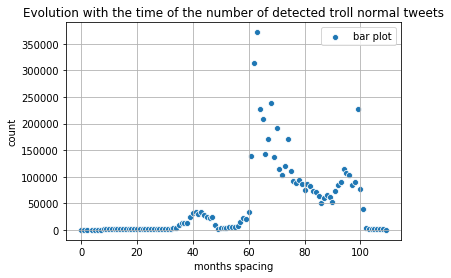

In [59]:
# plot purposes (whole data without truncating and
# without keeping only observations during the presidential campaign)
plt.figure(1)
sns.scatterplot(x = "months spacing", y="count", data=normal_dates_pd)
plt.title('Evolution with the time of the number of detected troll normal tweets')
plt.grid()
plt.xlabel('months spacing')
plt.ylabel('count')
plt.legend(['bar plot']);

We observe a peak starting after 61 months from May 2009 , thus in June 2014. This corresponds exactly to one year prior the moment when Donald Trump announced his candidacy for the primaries (republican) [wikipedia/donald_trump](https://en.wikipedia.org/wiki/Donald_Trump#Political_activities_up_to_2015). 

We'll have to determine whether the ***effective*** troll campaign did really (if it existed) start that month ; maybe to trigger in advance the aimed public.

After the peak the *troll* fever seems to drop monotically until 85 months after the very first tweets : it corresponds to June 2016 before growing up again **right before the final US elections** of november 2016). 

Trolls end after 100 months, at the beginning of the academic year 2017-2018 (Sep. 2017).

### Time window:  2014 -  2016

For the current Milestone, let's focus on that period of time since it corresponds to the whole presidential campaign (+ some time before as a flourishing speculative period)

Let's get some basic statistics about the feature *retweet_count* of that same *normal_tweets* dataframe. It could help us for our future analysis to evaluate/assess the importance of troll tweets. We do not dispose of view counts (at least for now) for such tweets but what can be sure is that there exists a correlation between the number of views and the number of retweets (the more a post is retweeted, the more likely that it reaches more and more people across the internet).

We can compare the summary statistics of *retweet_count* of normal tweets with statistics of typical 'popular' tweets on Twitter to get a kind of 'popularity scale'. Of course we have to be careful with the data we're dealing with : there might be some automatic retweet nested chains that would bias those results. We'll have to inform ourselves slightly more about that.

In [60]:
# get only the retweets counts (for years of interest, @tune)
normal_retweets_query = """SELECT retweet_count AS retweets
                        FROM normal_tweets_sql
                        WHERE YEAR(tweet_time)<2017 AND YEAR(tweet_time)>2013
                     """
normal_retweets_df = spark.sql(normal_retweets_query)

# relative error tolerance for median computation 
tol = 0.001

print('Summary statistics for RT counts for normal_tweets : ')
print('----------------------------------------------------')
normal_retweets_df.select('retweets').describe().show()
print('approx. 1st quarter quantile : '+str(normal_retweets_df.approxQuantile('retweets',[0.25],tol)[0])+\
      ' for relative error of '+str(tol))
print('approx. median : '+str(normal_retweets_df.approxQuantile('retweets',[0.5],tol)[0])+\
      ' for relative error of '+str(tol))
print('approx. 3rd quarter quantile : '+str(normal_retweets_df.approxQuantile('retweets',[0.75],tol)[0])+\
      ' for relative error of '+str(tol))

Summary statistics for RT counts for normal_tweets : 
----------------------------------------------------
+-------+-----------------+
|summary|         retweets|
+-------+-----------------+
|  count|          4034671|
|   mean|3.648541603516123|
| stddev|84.69370646803212|
|    min|                0|
|    max|            97498|
+-------+-----------------+

approx. 1st quarter quantile : 0.0 for relative error of 0.001
approx. median : 0.0 for relative error of 0.001
approx. 3rd quarter quantile : 0.0 for relative error of 0.001


**We presume that the vast majority of the normal tweets aren't given any RT!**

The *stddev* is huge, those statistics seem to indicate a ***power law*** distribution. 

Let's get the count distribution of the number of RT's. It fits into the memory since we only consider one column of $\simeq$ 5M observations. Nevertheless we won't store the Pandas for the rest of this notebook.

In [61]:
# let's discover the number of normal tweets that were RT more than 10 times
normal_retweets_sup1_query = """SELECT retweet_count AS retweets
                        FROM normal_tweets_sql
                        WHERE retweet_count>10 AND YEAR(tweet_time)<2017 AND YEAR(tweet_time)>2013
                     """
normal_retweets_sup1_df = spark.sql(normal_retweets_sup1_query)

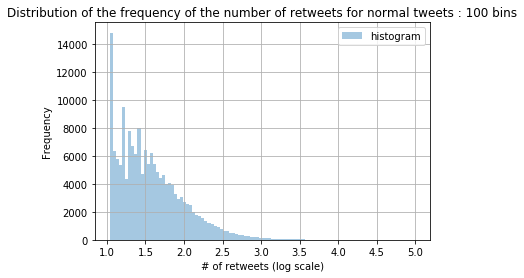

In [62]:
# => RT count distribution

## log scale - truncated

# plot purpose  
plt.figure(1)
nbins_global = 100
sns.distplot(normal_retweets_sup1_df.select('retweets').toPandas().apply(lambda x: np.log10(x)),\
             bins = nbins_global, norm_hist = False, kde = False)
plt.title('Distribution of the frequency of the number of retweets for normal tweets : ' +\
          str(nbins_global)+' bins')
plt.xlabel('# of retweets (log scale)')
plt.ylabel('Frequency')
plt.grid()
plt.legend(['histogram']);

The proportion of normal tweets that have been only RT less than 10 times is gigantic. 

In [63]:
# compute the required proportion
n_normal_RT_less10 = normal_retweets_df.count() - normal_retweets_sup1_df.count()

# print the results
print('proportion of normal tweets RT less than 10 times : '+str(n_normal_RT_less10/n_normal * 100)+'%')

proportion of normal tweets RT less than 10 times : 71.10914611691912%


No need to worry already : this is not sufficient evidence that there were no political inference through troll tweets during the US campaign of 2016. 

***But it actually may sustain the hypothesis of the existence of clever RT chains that relay the troll across the web at 'low cost' in terms of RTs.***

We will investigate why there are for the vast majority of the normal tweets, at first sight, so few RT's and if this phenomenon also arises on the reduced time windows mentionned earlier.

Still it can be interesting to extract the most RT normal tweets and have a look at their content (we keep the *tweetid*'s). 

We may also want to discover what is the langage used and to which accounts are linked these tweets (we also keep *userid*).

In [64]:
# get the 1000 (it could be more or less) most RT tweets

normal_retweets_top_query = """SELECT tweetid as id, userid AS user,retweet_count AS retweets,tweet_time
                        FROM normal_tweets_sql
                        WHERE YEAR(tweet_time)<2017 AND YEAR(tweet_time)>2013 
                        ORDER BY retweet_count DESC
                        LIMIT 1000
                     """
normal_retweets_top_df = spark.sql(normal_retweets_top_query)

# in order to have direct access on the computed top RT tweets (COMMENT IF LARGE TOP)
normal_retweets_top_df.persist()

# create temporary Spark SQL view 
normal_retweets_top_df.createOrReplaceTempView("normal_retweets_top_sql")

normal_retweets_top_df.show(20)

+------------------+----------+--------+-------------------+
|                id|      user|retweets|         tweet_time|
+------------------+----------+--------+-------------------+
|780901314079318016|4437233895|   97498|2016-09-27 22:45:00|
|785614679682846720|4437233895|   41089|2016-10-10 22:55:00|
|802239678267043840|4437233895|   30963|2016-11-25 19:56:00|
|812841804341067776|4859142199|   29998|2016-12-25 02:06:00|
|710499812223918080|3312143142|   28568|2016-03-17 16:15:00|
|796053302693822465|4224729994|   25790|2016-11-08 18:14:00|
|711543567387332608|3312143142|   25169|2016-03-20 13:23:00|
|799348218777702401|4859142199|   24540|2016-11-17 20:27:00|
|810201153199816704|4437233895|   20435|2016-12-17 19:13:00|
|809200393100132352|4859142199|   16844|2016-12-15 00:56:00|
|708741988481282048|3312143142|   16670|2016-03-12 19:50:00|
|784182493868023808|4437233895|   16627|2016-10-07 00:04:00|
|777989058689536000|4437233895|   16104|2016-09-19 21:53:00|
|750507193967845376|4437

Let's join to this table some features of interest as the language of the tweet, the self-reported location of the author (***maybe highly corrupted***), whether or not the tweet did embed a poll plug-in (this feature is maybe more important than *a priori* believed : answering a poll insidiously bias people) , the content of the tweet and finally author's number of followers.

In [65]:
# multiple JOIN instruction
informative_table_top_query = """
WITH tweets_stats_content AS (SELECT id, tweet_language, user, retweets ,tweet_text,tweet_time FROM normal_retweets_top_sql JOIN tweets_text_sql ON normal_retweets_top_sql.id = tweets_text_sql.tweetid),
all_but_localisation AS (SELECT tweetid, tweet_language, user, retweets ,tweet_text, follower_count as follow_numb, following_count as follow_cnt, tweet_client_name,tweet_time FROM tweets_stats_content JOIN tweets_meta_sql ON tweets_stats_content.id = tweets_meta_sql.tweetid),
all AS (SELECT user_reported_location, tweetid, tweet_language, user, retweets ,tweet_text, follower_count, following_count, tweet_client_name , tweet_time FROM all_but_localisation JOIN tweets_user_sql ON all_but_localisation.user = tweets_user_sql.userid)
SELECT user_reported_location, tweetid, tweet_language, user, retweets ,tweet_text, follower_count, following_count, tweet_client_name , YEAR(tweet_time) AS year, MONTH(tweet_time) AS MONTH FROM all
"""

Let's save the last result into a Parquet file !

In [66]:
# comment if already computed 
spark.sql(informative_table_top_query).write.mode('overwrite').parquet("informative_table_top")

Let's load the previously built Spark data frame in Parquet's format.

In [67]:
# read Parquet file
informative_table_top_df = spark.read.parquet("informative_table_top")

# load into Pandas (comment if large top)
informative_table_top_pd = informative_table_top_df.toPandas()

# quick review
informative_table_top_pd.head()

,user_reported_location,tweetid,tweet_language,user,retweets,tweet_text,follower_count,following_count,tweet_client_name,year,MONTH
0,"Россия, Москва",469529248634781697,ru,2351739462,1869,"""РФ в праве накладывать экономические и полити...",53175,5434,Twitter for iPhone,2014,5
1,None,639458604022632448,ru,2721995401,1783,Это волшебный твит. Сделай ретвит и учеба пойд...,37362,2617,Twitter Web Client,2015,9
2,"Richmond, VA",782397500741160964,en,4437233895,995,Marvel doing things right for once https://t.c...,56581,31117,Twitter Web Client,2016,10
3,None,785642386294579201,en,4224729994,1468,Trump invites a kid dressed up as Donald Trump...,147767,74664,Twitter Web Client,2016,10
4,None,787131633971425280,en,4224729994,1917,Donald Trump has sacrificed everything &amp; n...,147767,74664,TweetDeck,2016,10


Among the last table there seem to be really intricating tweets ! 

In [68]:
# user spotted as being a troll but doesn't have necessarily any link with russia
troll_example_df = informative_table_top_pd[informative_table_top_pd.user=='4224729994']
troll_example_df

,user_reported_location,tweetid,tweet_language,user,retweets,tweet_text,follower_count,following_count,tweet_client_name,year,MONTH
3,None,785642386294579201,en,4224729994,1468,Trump invites a kid dressed up as Donald Trump...,147767,74664,Twitter Web Client,2016,10
4,None,787131633971425280,en,4224729994,1917,Donald Trump has sacrificed everything &amp; n...,147767,74664,TweetDeck,2016,10
5,None,788016731650490368,en,4224729994,1375,"""""""This isn't a Justice Department anymore. Th...",147767,74664,TweetDeck,2016,10
6,None,788965973839769600,en,4224729994,1660,"""Crowd chanting """"DONALD TRUMP"""" right behind ...",147767,74664,Twitter Web Client,2016,10
10,None,808372041682452480,en,4224729994,1104,"Sorry Liberals, the Russians didn't hack Podes...",147767,74664,Twitter Web Client,2016,12
13,None,772190853485981696,en,4224729994,1417,Spread this AMAZING pic to piss off Liberals😏 ...,147767,74664,TweetDeck,2016,9
14,None,780505457018404864,en,4224729994,1183,BREAKING🚨 Benghazi survivor Mark Geist confir...,147767,74664,TweetDeck,2016,9
19,None,808044937786757120,en,4224729994,1846,"""""""Any Muslim in the US who believes in Sharia...",147767,74664,TweetDeck,2016,12
20,None,808852105842851840,en,4224729994,1160,"""MUST WATCH: Jim Brown on why he's """"pulling f...",147767,74664,Twitter Web Client,2016,12
25,None,787668421299150852,en,4224729994,2476,"""Rudy Giuliani on Hillary: """"You know what its...",147767,74664,TweetDeck,2016,10


In [69]:
# example of two troll tweets that may have some psychological impact on readers
troll_example = troll_example_df.loc[38]
troll_example2 = troll_example_df.loc[4]

# their content speaks for itself ...
troll_example['tweet_text']
troll_example2['tweet_text']

'Donald Trump has sacrificed everything &amp; now going through living hell to save America!   Show him some LOVE!  #MAGA https://t.co/b7vi38ecRp'

These tweets were produced during the presidential campaign (September 2016).
___________________________________________________________________________

Let's have a look at summary statistics about features of our dataframe (fields of interest of the most RT tweets).

In [70]:
# descriptive statistics of numerical fields
# (other than year or months that can ben considered as categorical in some sense)
informative_table_top_pd[['retweets','follower_count','following_count']].describe()

,retweets,follower_count,following_count
count,1000.000000,1000.000000,1000.00000
mean,2677.305000,92475.019000,45639.86600
std,4437.097288,51196.629291,27664.86657
min,995.000000,2688.000000,10.00000
25%,1218.750000,47413.000000,12977.00000
50%,1588.500000,72121.000000,42080.00000
75%,2576.750000,147767.000000,74664.00000
max,97498.000000,149672.000000,74664.00000


We can already see that the most RT tweets among our databases of troll tweets during the US presidential are produced by quite influent Twitter Accounts (median $\simeq 50$k). 

We've spent more time on exploring the questions 3) and 4) but we will further investigate this dataframe because it contains precious informations. Of course, it's likely that we're gonna choose not only the 1000 top RT normal tweets but maybe far more. 

In that latter case some of the previous computations may require Ada's cluster, without being certain for now. 

**We will investigate possible correlations betwen the number of normal tweets (of a certain kind; a filter has still to be constructed to assess the relevancy of those tweets) with Trump's popularity during the time window June 2014 - September 2017.** Therefore we first have to enrich our datasets with the popularity scores of Trump (and actually other opponents as there might be troll tweets aimed to discredit other candidates).

In [71]:
# investigate correlation between number of normal tweets with Trump's
# popularity during that time window (June 2014-September 2017)

# @ complete

**We will try to catch where do the troll tweets come from and where do they spead.** To this purpose we also have to enrich our dataset with some studies. But unlike the previous point, we are not sure about the existence of such piece of information.

In [72]:
# dig further into the 'importance' assessment of our troll tweets / try to figure out which 
# population had been 'touched' by the trolls 
# => we will try to infere this from the reported locations but some extra readings/thoughts are
# needed to ensure the validity of this process.

# @complete

To summarize, we have all the tools to answer to questions 1) and 2) properly thanks to the web-pages informed above. 

Only the last sub-question (actually not part of 1) nor 2), it's an extra) about the origin of troll tweets will be a bottleneck to overcome looking at more ressources on the internet ; if no satisfying ressource(s) is/are found, we will probably not answer it.

### Textual analysis
In order to answer to the questions 3 and 4 we must interest ourselves in the text of the tweets itself.

**Languages**

The first natural step is to identify the different languages present in our database. Let's group the tweets by languages and see which languages we will have to deal with.

+--------------+--------------+
|tweet_language|language_count|
+--------------+--------------+
|            ru|       4853185|
|            en|       3261931|
|           und|        526819|
|            de|         99332|
|            uk|         82237|
|            bg|         54690|
|            ar|         37245|
|            it|         20376|
|            es|         12802|
|            fr|         12636|
|            in|         10325|
|            sr|          8045|
|            tl|          6962|
|            ht|          6650|
|            et|          6146|
|            tr|          3927|
|            nl|          3541|
|            da|          3483|
|            sk|          3343|
|            ro|          3161|
+--------------+--------------+



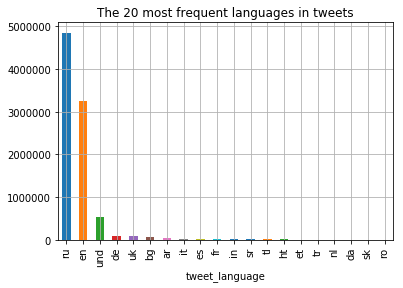

In [9]:
tweets_text_df.createOrReplaceTempView("tweets_text_sql") # Create temporary view to perform SQL operations

query_language = """WITH lang_counts AS (SELECT tweet_language, COUNT(tweet_language) AS language_count FROM tweets_text_sql GROUP BY tweet_language)
SELECT * FROM lang_counts ORDER BY language_count DESC LIMIT 20"""

language_count_df = spark.sql(query_language)

language_count_df.show()

# We can then draw a bar plot
language_count_df.toPandas().plot.bar(x = "tweet_language", y = "language_count",legend=False, 
                                      title="The 20 most frequent languages in tweets",grid=True)

We can see that there are a big variety of languages but the two big winners are the 'english' and the 'russian'. We will focus on those two for the moment.

We now have to identify the main subjects discussed in each tweet. Unfortunately none of us can speak russian, we nevetherless can translate these tweets with py-translate (Note that the translation is far from being perfect but at least we will have a global idea of what the tweets talk about).

First let us first restrict ourselves to the english and russian tweets

In [21]:
df_ru = spark.sql("""SELECT * FROM tweets_text_sql WHERE tweet_language = 'ru'""")
df_en = spark.sql("""SELECT * FROM tweets_text_sql WHERE tweet_language = 'en'""")
df_ru.show()
df_en.show()

+------------------+--------------+--------------------+
|           tweetid|tweet_language|          tweet_text|
+------------------+--------------+--------------------+
|877919995476496385|            ru|"RT @ruopentwit: ...|
|492388766930444288|            ru|Серебром отколоко...|
|536179342423105537|            ru|Предлагаю судить ...|
|834365760776630272|            ru|Двойная утопия, и...|
|577490527299457024|            ru|RT @harkovnews: Н...|
|596522755379560448|            ru|RT @NovostiNsk: «...|
|665533117369876480|            ru|RT @vesti_news: Ш...|
|701008777001107457|            ru|Генпрокуратура на...|
|725740300065366016|            ru|Кировский пасхаль...|
|704248884072046592|            ru|В Кирове на два м...|
|710845825622999040|            ru|Пятница в Кирове:...|
|648955031081758720|            ru|ИнстаКиров: топ п...|
|704222907304534016|            ru|"Что обсуждают в ...|
|860151003752132609|            ru|В музее Циолковск...|
|918116356117139459|           

Now let us translate the russian tweets into english. Translating all the tweets would be too expensive in time and money. Let us thus focus on the 15.000 moost important ones i.e. the 15.000 tweets with the highest retweet_count value.

In [32]:
df_ru.createOrReplaceTempView("df_ru_sql") # Create temporary view to perform SQL operations
# select 15000 most important tweets
importance_query = """WITH retweet AS (SELECT tweetid AS tweetid2, retweet_count FROM tweets_stats_sql ORDER BY retweet_count DESC LIMIT(15000))
SELECT tweetid, tweet_text FROM df_ru_sql JOIN retweet ON retweet.tweetid2 = df_ru_sql.tweetid"""
df_ru_sampled = spark.sql(importance_query)
df_ru_sampled.show()

+------------------+--------------------+
|           tweetid|          tweet_text|
+------------------+--------------------+
|818056880568365056|И то правда... ht...|
|779379418607325184|Белорусских парал...|
|808298986847272961|Фарион рассказыва...|
|732564713481986048|Сложный выбор: и ...|
|915857888098357249|Товарищи! Как вы ...|
|714734768156442624|ГЕРОЙ, ВЫЗВАВШИЙ ...|
|742691056223944704|Сборная России ус...|
|848611782893723649|Но тиран всё равн...|
|773794159043964928|Поддержите акцию ...|
|881544665710960641|В центре Киева ра...|
|836581455224504320|Всё, в ДНР начала...|
|873841280719171585|Прекрасное видео ...|
|718740064067534849|ШЕСТИМЕСЯЧНАЯ БЕС...|
|788749331440558081|В Киеве скажут, ч...|
|680652024258531328|Казарма ВСУ. И ве...|
|848924715330797570|Шмарам методички ...|
|751071804068769792|Хакер, взломавший...|
|731160274426843137|Время напомнить в...|
|802566128585375744|Бюст Сталина в Ли...|
|796271890398593024|Против Трампа был...|
+------------------+--------------

Let us define a function that sends HTTP request to the bin server (here we put subscriptionKey = 'xxx' ) because it is private information.

In [46]:
def translator(sentence, from_lang = 'ru', to_lang = 'en'):
    subscriptionKey = 'xxx'
    base_url = 'https://api.cognitive.microsofttranslator.com'
    path = '/translate?api-version=3.0'
    params = '&from=ru&to=en'
    constructed_url = base_url + path + params

    headers = {
        'Ocp-Apim-Subscription-Key': subscriptionKey,
        'Content-type': 'application/json',
        'X-ClientTraceId': str(uuid.uuid4())
    }

    body = [{
        'text' : sentence
    }]
    request = requests.post(constructed_url, headers=headers, json=body)
    response = request.json()

    return response[0]['translations'][0]['text']

Translate the tweets and save them to parquet.

In [43]:
df_ru_translated = df_ru_sampled.rdd.map(lambda r: (r[0],translator(r[1]))) # Translate the tweets
spark_df_ru_translated = spark.createDataFrame(df_ru_translated,['tweedid', 'tweet_text'])
spark_df_ru_translated.write.mode('overwrite').parquet("translated_tweets")

Here is what the translated tweets look like

In [14]:
translated_ru = spark.read.parquet("translated_tweets")
translated_ru.show()

+------------------+--------------------+
|           tweedid|          tweet_text|
+------------------+--------------------+
|888352384812019712|Marin Le Pen: We ...|
|883700663208824832|Elena Prikhodko, ...|
|838736168640466944|Is Litvinova okay...|
|696384621601300480|Ahahaha HTTPS://T...|
|884345115363487744|On July 10, 2016 ...|
|747049705104891904|"Bobyon is" the "...|
|870263243431964672|"Vanichka Nesteru...|
|781441079564468224|39-year-old resid...|
|704991386874019840|Northern Venice ?...|
|734372506300256256|Kiev was going to...|
|660440831283888128|All those who tod...|
|757853549615124481|Pushkov called Ru...|
|805075503329722368|URGENT NEWS! Syri...|
|502409560368623617|"Putin saw his ra...|
|760002770246197248|The Islamic State...|
|676811008262995969|"This is the" Pin...|
|731819715589488640|"Ukrainian politi...|
|735736512113827840|174 persons. But ...|
|817744710928367616|The Permiaki went...|
|877911586949738498|On June 22, 1990 ...|
+------------------+--------------

**Hashtags**

Another important aspect of the tweets are the hashtags. They represent a lot of information as they can tell about the subject of the tweet, the opinion of the tweeter, ...

Let us first interest ourselves in the english tweets

In [62]:
# Introduce a pattern to match into the form of a regexp
regexp = re.compile("\B#\w\w+",re.IGNORECASE)

# @goal : return all the matching expressions : i.e. '#word will be transformed to ['word']
def tag_split(text):
    return regexp.findall(text)

# Apply this first map in order to flatten expressions of the type #word1#word2 ... 
flattered_tweets = df_en.rdd.map(lambda r: (r[0],r[1],tag_split(r[2])))

# Going back to dataframes to enjoy the "explode" methods that does exactly what we need
tweets_new_df = spark.createDataFrame(flattered_tweets, ['tweetid','tweet_language','tweet_text'])

# Create another SQL view for questions with this new representation
tweets_new_df.withColumn('hashtag', explode(tweets_new_df.tweet_text)).createOrReplaceTempView("tweets_flat_sql")

+-----------------+---------+
|          hashtag|frequency|
+-----------------+---------+
|            #news|   241431|
|          #sports|    96669|
|        #politics|    76020|
|           #local|    53879|
|           #world|    28684|
|        #business|    26744|
|         #Chicago|    23401|
|          #health|    21983|
|            #love|    19172|
|            #MAGA|    18866|
|        #breaking|    16959|
|         #TopNews|    16407|
|           #Texas|    13007|
|#BlackLivesMatter|    12798|
|            #true|    12710|
|         #NewYork|    12149|
|   #Fukushima2015|    11720|
|            #Foke|    11090|
|             #USA|    11005|
|         #showbiz|    10866|
+-----------------+---------+



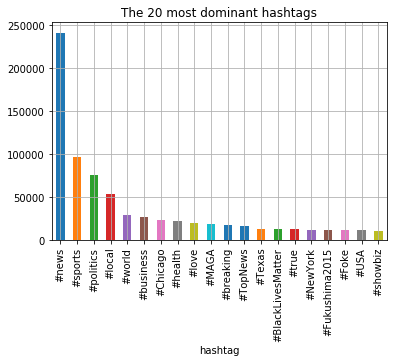

In [50]:
# Select the 20 most frequent hashtags
pre_query = """WITH hashtag_freq AS(SELECT hashtag, COUNT(tweetid) AS frequency FROM tweets_flat_sql GROUP BY hashtag)
SELECT * FROM hashtag_freq ORDER BY frequency DESC LIMIT(20)"""

hashtags_count_df = spark.sql(pre_query)
hashtags_count_df.show()

# Plot purposes
hashtags_count_df.toPandas().plot.bar(x = "hashtag", y = "frequency",legend=False, title="The 20 most dominant hashtags",grid=True)

As we can see the most used hashtags are those about news, sports and politics. This makes sense as these 3 topics are actively debated by all tweeter's users, trolls included

Now for the russian ones

In [51]:
# Apply this first map in order to flatten expressions of the type #word1#word2 ... 
flattered_tweets = translated_ru.rdd.map(lambda r: (r[0],tag_split(r[1])))

# Going back to dataframes to enjoy the "explode" methods that does exactly what we need
tweets_new_df = spark.createDataFrame(flattered_tweets, ['tweetid','tweet_text'])

# Create another SQL view for questions with this new representation
tweets_new_df.withColumn('hashtag', explode(tweets_new_df.tweet_text)).createOrReplaceTempView("tweets_flat_sql")

+--------------------+---------+
|             hashtag|frequency|
+--------------------+---------+
|                #ВСУ|       40|
|                #ДНР|       19|
|          #ПозорWADA|       10|
|      #АнгелыВсердце|        8|
|                #ЛНР|        7|
|      #БоженуКОтвету|        6|
|                 #RT|        5|
|   #ГивиВечнаяПамять|        5|
|     #АвгустВосьмого|        5|
|   #ПодвигЛенинграда|        5|
|            #Дети101|        4|
| #FreeGrahamPhillips|        4|
|      #StopMorganLie|        4|
|           #ЯНеШарли|        3|
|   #УмираюНоНеСдаюсь|        3|
|       #ПамятиБузины|        3|
|#ИспортиМеняДеньгами|        3|
|#СвободуМехтиЛогу...|        3|
|#ДеньВетеранаБоев...|        3|
|        #СлужуРоссии|        3|
+--------------------+---------+



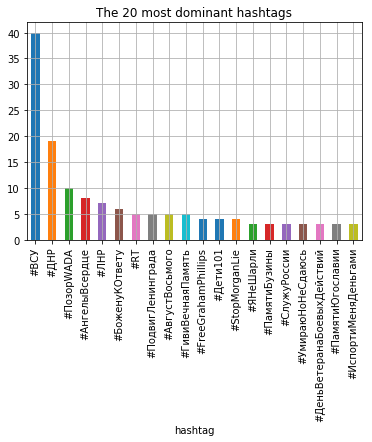

In [52]:
# Select the 20 most frequent hashtags
pre_query = """WITH hashtag_freq AS(SELECT hashtag, COUNT(tweetid) AS frequency FROM tweets_flat_sql GROUP BY hashtag)
SELECT * FROM hashtag_freq ORDER BY frequency DESC LIMIT(20)"""

hashtags_count_df = spark.sql(pre_query)
hashtags_count_df.show()

# Plot purposes
hashtags_count_df.toPandas().plot.bar(x = "hashtag", y = "frequency",legend=False, title="The 20 most dominant hashtags",grid=True)

The tweets are in a special structure that disallow them from translation. But googling the five dominant tweets teaches that
* ВСУ is the "Armed Forces of Ukraine"
* ДНР is Donetsk People's Republic which is a proto-state of Ukraine
* ПозорWADA which talks about the cancellation of the russian paralympic games
* АнгелыВсердце refers to the events of the killed children of dombass
* ЛНР means Luhansk People's Republic which is another proto-state of Ukraine

These 5 hashtags refer all to highly controversated events, which again makes sense for highly retweeted tweets.  

**Words**

Now that we have analysed the hashtags, let us focus on the words themselves. This allows to see what are the typical words used by trolls. A comparison between most frequent words between troll and normal tweets is one of the nice plus that we could do for Milestone 3.

Note : we will remove the hastags words for this analysis

Let us first clean the tweets. Indeed a tweet contains a lot of noisy information i.e. links, RT, @somebody, #word, ...

Furthermore, a lot of variants of the same words exists. This is why we can use stemming to bring every word into its most reduced form.

Finally, every tweet contains stopwords i.e. words that we must use to build sentence but don't bring any particuliar information on the tweet itself (e.g. 'it', 'me', 'then', ...). These words can be removed to do some particuliar analysis.

In [11]:
stemmer = nltk.SnowballStemmer("english", ignore_stopwords=True)  # Initialize stemmer that 'kills' also stopwords
# custom list of stopwords
stopwords = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself',
             'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself',
             'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'these',
             'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do',
             'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while',
             'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before',
             'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again',
             'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each',
             'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than',
             'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should', 'now', 'd', 'll', 'm', 'o', 're', 've',
             'y', 'ain', 'aren', 'couldn', 'didn', 'doesn', 'hadn', 'hasn', 'haven', 'isn', 'ma', 'mightn', 'mustn',
             'needn', 'shan', 'shouldn', 'wasn', 'weren', 'won', 'wouldn', 'make', 'go', 'get', "it's", 'us', '&amp;',
            'want', 'get', 'new', "don't", "i'm", 'one', 'say']

def tweet_cleaner(text, stem_option = True):
    """This function takes a String as input and returns a 'cleaned' version of it.
    -> No punctuation
    -> No links, hashtags, ...
    -> Stemming if stem_option = True"""
    text = re.sub(r'[.,"!,-]+', '', text, flags=re.MULTILINE)  # removes the characters specified
    text = re.sub(r'^RT[\s]+', '', text, flags=re.MULTILINE)  # removes RT
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)  # remove link
    text = re.sub(r'[:]+', '', text, flags=re.MULTILINE)
    new_line = ''
    for i in text.split():  # remove @ and # words
        stemmed_word = stemmer.stem(i)
        if not i.startswith('@') and not i.startswith('#') and stemmed_word not in stopwords:
            new_line += stemmed_word + ' '
    return new_line

In [54]:
flattered_tweets = df_en.rdd.map(lambda r: (r[0],r[1],tweet_cleaner(r[2]).split()))

# Going back to dataframes to enjoy the "explode" methods that does exactly what we need
tweets_new_df = spark.createDataFrame(flattered_tweets, ['tweetid','tweet_language','tweet_text'])

# Create another SQL view for questions with this new representation
tweets_new_df.withColumn('words', explode(tweets_new_df.tweet_text)).createOrReplaceTempView("tweets_flat_sql")

+-----+---------+
|words|frequency|
+-----+---------+
|trump|   167649|
| like|    88270|
|  man|    86826|
|peopl|    84851|
|polic|    69916|
| love|    68141|
|obama|    64820|
| time|    61898|
|  day|    56506|
| know|    56196|
| look|    53795|
| kill|    52407|
| need|    49538|
| take|    48906|
|black|    46925|
| life|    46005|
|never|    45836|
| call|    45589|
| live|    44542|
| year|    44538|
+-----+---------+



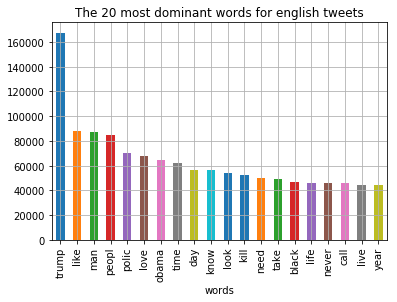

In [55]:
# Select the 20 most frequent words
pre_query = """WITH word_freq AS(SELECT words, COUNT(tweetid) AS frequency FROM tweets_flat_sql GROUP BY words)
SELECT * FROM word_freq ORDER BY frequency DESC LIMIT(20)"""

words_count_df = spark.sql(pre_query)
words_count_df.show()

# Plot purposes
words_count_df.toPandas().plot.bar(x = "words", y = "frequency",legend=False, title="The 20 most dominant words for english tweets",grid=True)

Without any surprise the most frequent word is trump. Some other interesting words also appear such as 
* obama : Obama was a great supporter of the main opponent of Trump that is Hillary Clinton. A theory would be that the trolls tried to discredit Obama's opinion
* black : A word with a negative connotation. Trump supporters are considered by many to be racist.
* kill : Again another word with negative connotation. A lot of interpretations are possible here.

Now for the russian tweets

In [56]:
flattered_tweets = translated_ru.rdd.map(lambda r: (r[0],tweet_cleaner(r[1]).split()))

# Going back to dataframes to enjoy the "explode" methods that does exactly what we need
tweets_new_df = spark.createDataFrame(flattered_tweets, ['tweetid','tweet_text'])

# Create another SQL view for questions with this new representation
tweets_new_df.withColumn('words', explode(tweets_new_df.tweet_text)).createOrReplaceTempView("tweets_flat_sql")

+---------+---------+
|    words|frequency|
+---------+---------+
|  russian|      198|
|     year|      185|
|   russia|      171|
|    peopl|      165|
|ukrainian|      150|
|   ukrain|      137|
|      day|      116|
|    today|      113|
|      die|      107|
|     kill|      105|
|   memori|      104|
|     hero|      104|
| children|       96|
|  support|       75|
|    world|       74|
|  countri|       71|
|     live|       70|
| american|       67|
|    putin|       63|
|    state|       63|
+---------+---------+



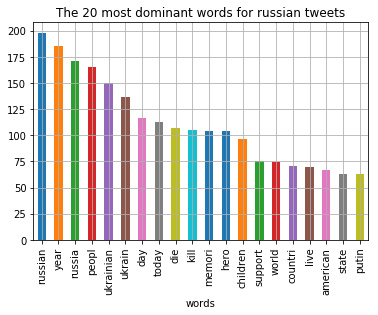

In [57]:
# Select the 20 most frequent words
pre_query = """WITH word_freq AS(SELECT words, COUNT(tweetid) AS frequency FROM tweets_flat_sql GROUP BY words)
SELECT * FROM word_freq ORDER BY frequency DESC LIMIT(20)"""

words_count_df = spark.sql(pre_query)
words_count_df.show()

# Plot purposes
words_count_df.toPandas().plot.bar(x = "words", y = "frequency",legend=False, title="The 20 most dominant words for russian tweets",grid=True)

While the 3 most used words (russian-year-russia) don't bring any useful information, the interesting thing to note is the presence of both ukrainian and ukrain in the top 6 ! This confirms the previous section in showing that the Ukrain is a highly contraversated subject in Russia. 

**Semantic analysis**

We can now finally try to analyse the construction of each tweet, what it talks about, the subjects of each tweet.

Let us focus here on a toy example of 1000 tweets and clean those tweets (conserving the stopwords and not stemming !)

In [93]:
df_en.createOrReplaceTempView("tweets_text_en_sql") # Create temporary view to perform SQL operations
toy_example = spark.sql("""SELECT tweet_text FROM tweets_text_en_sql LIMIT 1000""")

toy_example_pd = toy_example.toPandas()
print('Tweets before cleaning : ' + str(toy_example_pd) + '\n')
toy_example_cleaned = toy_example_pd.apply(lambda x : tweet_cleaner(x, stem_option = False))
print('Tweets after cleaning : ' + str(toy_example_cleaned))

Tweets before cleaning :                                             tweet_text
0    As sun and cloud give way to moon and shadow, ...
1               Down in the comfort of strangers, I...
2                  Im laughing more than i should #USA
3                         No, I'm not saying I'm sorry
4                        Laugh it all off in your face
5    It takes courage to make a fool of yourself. –...
6        I want to be normal and live with a boyfriend
7    « Reverie is when ideas float in our mind with...
8    Meet The Democrat’s Next “OBAMA” https://t.co/...
9    Kellyanne Conway denies reports of leaking con...
10   RT @e933848ee109a3e968bfefb54a785c0426edab39c1...
11   Some books should be tasted, some devoured, bu...
12           I need this skill https://t.co/2X4DHRVp2W
13   RT @Danimal941: No shirt, no shoes, no sanctua...
14   RT @MTVNews: SO. DAMN. CUTE. https://t.co/tiUj...
15   RT @Real923LA: A few of our lucky listeners ha...
16   RT @ReignOfApril: The Immortal Life

TypeError: ('expected string or bytes-like object', 'occurred at index tweet_text')

We can clearly see that the data is now much more suitable for performing text processing operations. 

The library we will use is called spacy. It is an open-source library that provides a bunch of text-processing functions (these operations are performed using neural networks).

The main operation that the library provides is the **nlp function** which allows us to derive what the tweet is talking about by identifying identities such as PERSON, ORG, DATE, ...

In [94]:
# Load English tokenizer, tagger, parser, NER and word vectors
nlp = spacy.load('en') # 'en' for english analysis

# Loop through every tweet and perfrom text analysis
for i, tweet in enumerate(toy_cleaned):
    print(tweet)
    print('Analysis of tweet ' + str(i) + '\n')
    analysis = nlp(tweet)
    # Find named entities, phrases and concepts
    for entity in analysis.ents:
        print(entity.text, entity.label_)
    print('\n')

As sun and cloud give way to moon and shadow the rhythm of the world makes itself apparent saying have faith in yourself you are this 
Analysis of tweet 0



Down in the comfort of strangers I 
Analysis of tweet 1



Im laughing more than i should USA 
Analysis of tweet 2

USA GPE


No I'm not saying I'm sorry 
Analysis of tweet 3



Laugh it all off in your face 
Analysis of tweet 4



It takes courage to make a fool of yourself – Charlie Chaplin 
Analysis of tweet 5

Charlie Chaplin PERSON


I want to be normal and live with a boyfriend 
Analysis of tweet 6



« Reverie is when ideas float in our mind without reflection or regard of the understanding » John Locke 
Analysis of tweet 7

Reverie PERSON
John Locke PERSON


Meet The Democrat’s Next “OBAMA” 
Analysis of tweet 8

Democrat NORP


Kellyanne Conway denies reports of leaking confidential information at a party 
Analysis of tweet 9

Kellyanne Conway PERSON


Saw it several days ago during a trip and that's amazing Can you see th

Less than 46000 minutes TIME
Obama ORG


BREAKING National Union of Healthcare Workers Declares Themselves Sanctuary for Illegals 
Analysis of tweet 146

National Union of Healthcare Workers Declares ORG


Diary kept by John F Kennedy during brief stint as journalist after WWII sells for more than $718000 at auction 
Analysis of tweet 147

John F Kennedy PERSON
WWII EVENT
more than $718000 MONEY


And we gon' be together until your moms move in (oh-hooo) love rap 
Analysis of tweet 148



I know that all these nuclear experiments in Ukraine will cause a real disaster god it happened Fukushima2015 
Analysis of tweet 149

Ukraine GPE


AMAZING PROOF OF REAL REPTILIANS⚫SAME REPTILIAN SHAPESHIFTING LIVE ON TW@a95a911dd6ae864c48ed062cdbe75e5c28dbe0cf57c6db3fa9dd53b654ee9845 u are there 
Analysis of tweet 150

TW@a95a911dd6ae864c48ed062cdbe75e5c28dbe0cf57c6db3fa9dd53b654ee9845 GPE


Pesticide - not Zika - eyed in Brazilian birth defects newspaper says news 
Analysis of tweet 151

Zika - eyed

THERE IS NO UCKING ALLAH A MYTHICAL god OF NOTHING ISLAM IS AN EVIL ; VILE &amp; VENAL RUTHLESS CULT FROM THE GATES OF… 
Analysis of tweet 261

MYTHICAL PERSON
ISLAM ORG
VILE & ORG
VENAL RUTHLESS CULT ORG
THE GATES OF… ORG


Yes they do and now they will help us fight this by closing in on them and cutting off the money 
Analysis of tweet 262



“If you tell me he is dead I will tell you why I did it” 
Analysis of tweet 263



NOT TO WORRY HISTORY BUFFS Hillary can STILL make history by being the first candidate of a major party to be led off i… 
Analysis of tweet 264

Hillary PERSON
first ORDINAL


DEVELOPING Cops hunt for an armed and dangerous man who reportedly killed someone while broadcasting on Facebook 
Analysis of tweet 265

Facebook ORG


loved this man he WAS RUNNING AGINST KILLER CLINTON SHE HAD IT DONE AND SOON WILL PAY U CAN TAKE THAT TO THE BANK🖕I SEE H… 
Analysis of tweet 266

HAD ORG


🚨SanctuarySewer🚨 🚨RockvilleRape🚨 🚨All the President's Lies🚨 🚨BuildTheWall🚨 🚨ConfirmG



hope you need my love just like I need you 
Analysis of tweet 378



Don?t look a gift horse in the mouth 
Analysis of tweet 379



After two periods of play NYR prospects still trail the Blues 1-0 and are down 16-14 in shotsstart third period on the PP… 
Analysis of tweet 380

two CARDINAL
NYR ORG
the Blues 1-0 PRODUCT
16-14 CARDINAL
third ORDINAL
PP PERSON


Voltage spikes 
Analysis of tweet 381



i got the honey that ya love to taste kind 
Analysis of tweet 382



adsnn VIDEO Hannity SHREDS McConnell “Stop Whining and Get to Work” 
Analysis of tweet 383

VIDEO Hannity ORG
“Stop Whining ORG


adsnn Insane Dictator’s Son THREATENS to “Take the White House” from Trump 
Analysis of tweet 384

Insane Dictator’s Son THREATENS PERSON
“Take the White House WORK_OF_ART
Trump ORG


Brussels airport restart delayed after police demands world news 
Analysis of tweet 385

Brussels GPE


Liberals are always trying to turn men into girls - sometimes they succeed Enlist with us at… 
Analysis of 

The Aryan Nations skinheads of the past control the GOP teaparty today Trump's Aryan America TCOT MAGA 
Analysis of tweet 514

The Aryan Nations ORG
GOP ORG
today DATE
Trump's Aryan America TCOT MAGA ORG


Wu-Tang Clan - A Better Tomorrow 
Analysis of tweet 515

Wu-Tang Clan - A PERSON
Tomorrow DATE


He's rancid Pence 
Analysis of tweet 516



Trump is reiterating some of the most dangerous lines from previous years &amp; revolting movements like his own P https… 
Analysis of tweet 517

previous years DATE


djs Best $599 promotion for Spinrilla mixtape click link for details 1700 plays 5k views 500 downloads 
Analysis of tweet 518

599 MONEY
Spinrilla PERSON
1700 CARDINAL
5k CARDINAL
500 CARDINAL


The LIVEST Foreign Party has landed🛬 🔥🥇🏆AfrOLYMPICS🏆🥇🔥 TeamNaija vs TeamUSA vs TeamJamaica + MORE🇹🇹🇬🇾🇬🇭 🎟 https/… 
Analysis of tweet 519

🥇🏆AfrOLYMPICS ORG
🥇 GPE
TeamUSA NORP
TeamJamaica + MONEY
🇹🇹 ORG
🇬 GPE
🇭 ORDINAL


WLS Sports JOEL EMBIID TO RIHANNA 'I LOVE YOU Hit Me Up ( Video ) - 
A

St Tammany chamber committee to present Leadership Summit news 
Analysis of tweet 637

Leadership Summit PERSON


Dems prepare amendments to Keystone bill after Senate okays vote -- with David Vitter voting yes and Bill Cassidy not voting news 
Analysis of tweet 638

Dems NORP
Keystone PERSON
Senate ORG
David Vitter PERSON
Bill Cassidy PERSON


politics Obama Kerry condemn terror attack in France 
Analysis of tweet 639

Obama Kerry PERSON
France GPE


Alvin Gentry 'We have to some kind of way figure out how we can be consistent' news 
Analysis of tweet 640

Alvin Gentry ' PERSON


Wrapping up doors tonight Noticed this neighbor vs neighbor Foreshadowing? We will win April 18th GA6 DefendThe6th MA… 
Analysis of tweet 641

tonight TIME
Noticed PERSON
Foreshadowing FAC
April 18th DATE


Patriots boycott loud mouth Amy's new movie Snatched BTW Goldie becoming the new Michael Jackson Just stop cutting Boy… 
Analysis of tweet 642

Amy PERSON
Snatched PERSON
Goldie PERSON
Michael Jackson PERS




Need then all 
Analysis of tweet 700



Dead president's corpse in the driver's car love America 
Analysis of tweet 701

America GPE


Adversity is a good teacher 
Analysis of tweet 702

Adversity ORG


Kim's face before she was famous 
Analysis of tweet 703

Kim PERSON


Power after love is the first source of happiness 
Analysis of tweet 704

first ORDINAL



Analysis of tweet 705



If you asked me what I came into this world to do I will tell you I came to live out loud 
Analysis of tweet 706




Analysis of tweet 707



Shark Dressed Man OneLetterOffSongs 
Analysis of tweet 708

Shark Dressed Man PERSON


AWWWWWWWWWW That’s awesome 
Analysis of tweet 709

AWWWWWWWWWW ORG


ReasonsToLieToKids Because they either believe literally anything or they question literally everything There is no in-be… 
Analysis of tweet 710



Just imagine our life full of love 
Analysis of tweet 711



Moscow summer 2017 - bringing you all the water you could possibly need and then some 
Analysis of t


Hayward Car PRODUCT


Folk are too busy calling shit evil to recognize the dysfunctional and abusive dynamics that play out in American homes… 
Analysis of tweet 777

American NORP


Downtown Berkeley BART reopens after protest closure 
Analysis of tweet 778

Berkeley BART EVENT


JaguarXX Chemical X Mixtape 
Analysis of tweet 779



of NEXT on stage at the Overtown Music &amp; Arts Festival OMA17 
Analysis of tweet 780

NEXT ORG
the Overtown Music &amp ORG
Arts Festival EVENT


I don’t give a fuck 
Analysis of tweet 781



Now and then it's good to pause in our pursuit of happiness and just be happy 
Analysis of tweet 782



Go and tell a nigga no with an ass so fat hey why you wanna do that love huh hey why you wanna do that 
Analysis of tweet 783



Fukushima2015 Ukraine was forced to shut down a reactor I guess you are softheaded Nukraine 
Analysis of tweet 784

Ukraine GPE
Nukraine ORG


WEDNESDAY 
Analysis of tweet 785

WEDNESDAY DATE


The World According to Gary Mugsy shots ne

Five CARDINAL


Record-breaking attendance for 40th San Francisco Marathon 
Analysis of tweet 852

40th ORDINAL
San Francisco Marathon EVENT


Public pool electrocution death of teen lifeguard in North Carolina raises safety conc 
Analysis of tweet 853

North Carolina GPE


Highway 17 In Santa Cruz Mountains Closed In Search For Robbery Suspect 
Analysis of tweet 854

Santa Cruz Mountains GPE
Search For Robbery Suspect ORG


San Rafael Mulls More Extensive Use Of License Plate Reading Cameras 
Analysis of tweet 855

San Rafael GPE


Fmr President George HW Bush discharged from hospital 
Analysis of tweet 856

George HW Bush PERSON


Strickland gets 6-game suspension after Giants Nationals brawl Harper gets 4 
Analysis of tweet 857

Strickland GPE
Giants Nationals ORG
Harper ORG
4 CARDINAL


The World According to Gary Steph Curry tees off 
Analysis of tweet 858

Gary Steph Curry PERSON


San Jose police seize 'extraordinary' 2700 pounds of illegal fireworks 
Analysis of tweet 859

San 

Please tell me someone why does Paul Ryan not fear anyone in the Republican party? That is not normal We all hate him… 
Analysis of tweet 989

Paul Ryan PERSON
the Republican party ORG


My mother had a great deal of trouble with me but I think she enjoyed it 
Analysis of tweet 990



I love this 💙 
Analysis of tweet 991

💙 PERSON


Muh ObamaLegacy The Decimated Democratic Party Dems lost 900+ State legislature seats👏12 Governors👏69 House seats👏13 Sena… 
Analysis of tweet 992

Muh ObamaLegacy PERSON
The Decimated Democratic Party Dems ORG
12 CARDINAL
69 CARDINAL
House ORG
13 CARDINAL
Sena ORG


ICYMI BREAKING Look Who Won TIME ‘Person of The Year’ 
Analysis of tweet 993

Year’ GPE


It's the Reid Option Get it right 
Analysis of tweet 994

the Reid Option Get PRODUCT


The occasional non-political tweet seems to be gaining popularity Figured I would try my luck with a little self estee… 
Analysis of tweet 995



Sergeant Joshua Berry was wounded during the Ft Hood terror attack - which

As we can see, the semantic analysis is (barely) not working ! The tweets are just too short sentences and/or are using too many links/hashtags, getting in the way of the global understanding of the tweet.

Studying the semantic of the tweets is therefore a (too) complicated operation, which may be dropped for next milestone.

### Support or hate ?

This question is quite difficult to answer such prematurely. However, what we can do for now is what is called a ***sentiment analysis***. This problem is a machine learning classification problem that tries to classifiy a tweet as 'positive' or 'negative'. While it doesn't totally answer to the question 5, it is still a good start that could be reused afterwards.

The first step of a sentiment analysis is to define words that we consider to be respectively positive, negative.

In [13]:
def read_file(file):
    f = open(file, 'r')
    words = []
    for word in f:
        words += [stemmer.stem(word[:len(word)-2])]
    f.close()
    return words

# Build the negative and positive word lists
neg_words = read_file('negative.txt')
print('Negative words : ' + str(neg_words))
pos_words = read_file('positive.txt')
print('Positive words : ' + str(pos_words))

Negative words : ['2-face', '2-face', 'abnorma', 'aboli', 'abominabl', 'abominabl', 'abominat', 'abominatio', 'abor', 'abort', 'abort', 'abrad', 'abrasiv', 'abrup', 'abruptl', 'abscon', 'absenc', 'absent-mind', 'absent', 'absur', 'absurdit', 'absurdl', 'absurdn', 'abus', 'abus', 'abus', 'abusiv', 'abysma', 'abysmal', 'abi', 'accidenta', 'acco', 'accurs', 'accusatio', 'accus', 'accus', 'accus', 'accusin', 'accusingl', 'acerbat', 'acerbi', 'acerbical', 'ach', 'ach', 'ach', 'ach', 'achin', 'acri', 'acridl', 'acridn', 'acrimoniou', 'acrimoniousl', 'acrimon', 'adaman', 'adamantl', 'addic', 'addict', 'addictin', 'addict', 'admoni', 'admonish', 'admonishingl', 'admonishmen', 'admonitio', 'adulterat', 'adulter', 'adulteratio', 'adulteri', 'adversaria', 'adversar', 'adver', 'adversit', 'afflic', 'afflictio', 'afflictiv', 'affron', 'afrai', 'aggravat', 'aggravatin', 'aggravatio', 'aggressio', 'aggressiv', 'aggressiven', 'aggresso', 'aggriev', 'aggriev', 'aggrivatio', 'agha', 'agoni', 'agoniz', '

Positive words : ['a', 'aboun', 'abound', 'abundanc', 'abundan', 'accessabl', 'accessibl', 'acclai', 'acclaim', 'acclamatio', 'accolad', 'accolad', 'accommodativ', 'accomodativ', 'accompli', 'accomplish', 'accomplishmen', 'accomplish', 'accurat', 'accuratel', 'achievabl', 'achievemen', 'achiev', 'achievibl', 'acum', 'adaptabl', 'adaptiv', 'adequat', 'adjustabl', 'admirabl', 'admirabl', 'admiratio', 'admir', 'admir', 'admirin', 'admiringl', 'adorabl', 'ador', 'ador', 'ador', 'adorin', 'adoringl', 'adroi', 'adroitl', 'adulat', 'adulatio', 'adul', 'advanc', 'advantag', 'advantageou', 'advantageousl', 'advantag', 'adventuresom', 'adventurou', 'advocat', 'advoc', 'advoc', 'affabilit', 'affabl', 'affabl', 'affectatio', 'affectio', 'affectionat', 'affinit', 'affir', 'affirmatio', 'affirmativ', 'affluenc', 'affluen', 'affor', 'affordabl', 'affordabl', 'afordabl', 'agil', 'agilel', 'agilit', 'agreeabl', 'agreeablen', 'agreeabl', 'all-aroun', 'allurin', 'alluringl', 'altruisti', 'altruistical', 

We can note that the method below is pretty naive. An improvement would be to use sentence instead of just words, we will just focus on the naive analysis for the moment. A more complex analysis is performed a bit more below.

In [14]:
# Predict
def sentiment_prediction(sentence):
    """Predict neutral, positive and negative depending on the words in the sentence"""
    neg = 0
    pos = 0
    sentence = sentence.lower()
    words = sentence.split(' ')
    for word in words:
        stemmed_word = stemmer.stem(word)
        if stemmed_word in neg_words:
            neg = neg + 1
        if stemmed_word in pos_words:
            pos = pos + 1
    if pos == neg:
        return 'neutral'
    elif pos > neg:
        return 'positive'
    else:
        return 'negative'
    
print('Example, I hate Trump is : ' + sentiment_prediction('I hate Trump'))

Example, I hate Trump is : negative


#### English tweets

In [15]:
# Predict each tweet with the above method
prediction_rdd = df_en.rdd.map(lambda r: (r[0],r[1], r[2], sentiment_prediction(tweet_cleaner(r[2]))))
prediction_df = spark.createDataFrame(prediction_rdd, ['tweetid','tweet_language', 'tweet_text', 'prediction']) # New dataframe
prediction_df.show()

+------------------+--------------+--------------------+----------+
|           tweetid|tweet_language|          tweet_text|prediction|
+------------------+--------------+--------------------+----------+
|567357519547207680|            en|As sun and cloud ...|  negative|
|493894187079974912|            en|Down in the comfo...|   neutral|
|493688319902220288|            en|Im laughing more ...|   neutral|
|497543470211678209|            en|No, I'm not sayin...|   neutral|
|500956712657223680|            en|Laugh it all off ...|   neutral|
|548763776267218944|            en|It takes courage ...|  positive|
|577477794218668032|            en|I want to be norm...|   neutral|
|553095178118893568|            en|« Reverie is when...|  positive|
|873202881222111233|            en|Meet The Democrat...|   neutral|
|874244693307031552|            en|Kellyanne Conway ...|  negative|
|631377234847248384|            en|RT @e933848ee109a...|   neutral|
|578225585706545152|            en|Some books sh

Let us compare the number of positive and negative tweets in our all tweets

In [16]:
# Let us see the count of every prediction
prediction_df.createOrReplaceTempView("prediction_sql")

pred_count_df = spark.sql('SELECT prediction, COUNT(tweetid) AS frequency FROM prediction_sql GROUP BY prediction')
pred_count_df.show()

+----------+---------+
|prediction|frequency|
+----------+---------+
|  positive|   662708|
|   neutral|  1676074|
|  negative|   923149|
+----------+---------+



And plot the results as a pie chart

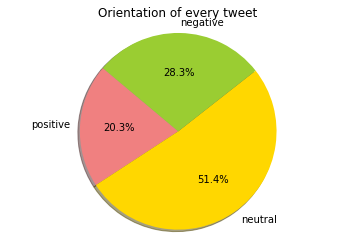

In [91]:
# Data to plot
pred_count_df_pd = pred_count_df.toPandas()
labels = pred_count_df_pd['prediction']
sizes = pred_count_df_pd['frequency']
colors = ['lightcoral', 'gold', 'yellowgreen']
 
# Plot
plt.pie(sizes, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
 
plt.axis('equal')
plt.title('Orientation of every tweet')
plt.show()

As we can see the tweets seem to be more negative than positive (given our naive algorithm)

A much more interesting idea would be to apply the same reasoning but only for the tweets containing the word 'Trump' and 'Obama'. That way we will be able to see if the tweets related to Trump or Obama were more positive or negative.

In [66]:
# Count predictions' orentiations for Trump tweets
query_prediction = """WITH trump_tweet AS (SELECT tweetId, prediction FROM prediction_sql WHERE tweet_text LIKE '%Trump%')

SELECT prediction, COUNT(tweetid) AS frequency FROM trump_tweet GROUP BY prediction"""

pred_trump_count_df = spark.sql(query_prediction)
pred_trump_count_pd = pred_trump_count_df.toPandas()

In [67]:
# Count predictions' orentiations for Obama tweets
query_prediction = """WITH obama_tweet AS (SELECT tweetId, prediction FROM prediction_sql WHERE tweet_text LIKE '%Obama%')

SELECT prediction, COUNT(tweetid) AS frequency FROM obama_tweet GROUP BY prediction"""

pred_obama_count_df = spark.sql(query_prediction)
pred_obama_count_pd = pred_obama_count_df.toPandas()

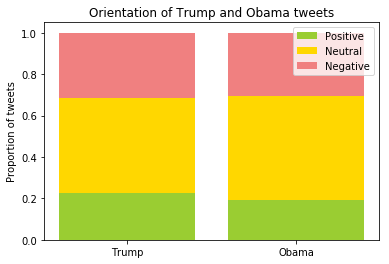

In [90]:
# Plot stacked bars
ind = np.arange(2)
positive_trump = pred_trump_count_pd.loc[pred_trump_count_pd['prediction'] == 'positive']['frequency'].values[0]
neutral_trump = pred_trump_count_pd.loc[pred_trump_count_pd['prediction'] == 'neutral']['frequency'].values[0]
negative_trump = pred_trump_count_pd.loc[pred_trump_count_pd['prediction'] == 'negative']['frequency'].values[0]
total = positive_trump + neutral_trump + negative_trump
positive_trump /= total
neutral_trump /= total
negative_trump /= total

positive_obama = pred_obama_count_pd.loc[pred_obama_count_pd['prediction'] == 'positive']['frequency'].values[0]
neutral_obama = pred_obama_count_pd.loc[pred_obama_count_pd['prediction'] == 'neutral']['frequency'].values[0]
negative_obama = pred_obama_count_pd.loc[pred_obama_count_pd['prediction'] == 'negative']['frequency'].values[0]
total = positive_obama + neutral_obama + negative_obama
positive_obama /= total
neutral_obama /= total
negative_obama /= total

positives = [positive_trump, positive_obama]
neutrals = [neutral_trump, neutral_obama]
negatives = [negative_trump, negative_obama]

p1 = plt.bar(ind, positives, color='yellowgreen')
p2 = plt.bar(ind, neutrals, color='gold', bottom = positives)
p3 = plt.bar(ind, negatives, color='lightcoral', bottom = [x+y for x,y in zip(neutrals, positives)])

plt.ylabel('Proportion of tweets')
plt.title('Orientation of Trump and Obama tweets')
plt.xticks(ind, ('Trump', 'Obama'))
plt.legend((p1[0], p2[0], p3[0]), ('Positive', 'Neutral', 'Negative'))

From these observations we can already observe that the tweets about Trump are more polarised than those about Obama. In addition, the tweets tend to be more positive when talking about Trump. 

### Further analysis

We will now apply a much more powerful tool to perform sentiment analysis : **VaderSentimentAnalyser** and see if the tendancy remains the same that in the naive case.

In [29]:
analyzer = SentimentIntensityAnalyzer() # Initiate analyser

In [33]:
# Positive analysis
pos_rdd = df_en.rdd.map(lambda r: (r[0],r[2], analyzer.polarity_scores(tweet_cleaner(r[2]))['pos']))
pos_df_en = spark.createDataFrame(pos_rdd, ['tweetid', 'tweet_text', 'pos_score']) # New dataframe
pos_df_en.show()

+------------------+--------------------+---------+
|           tweetid|          tweet_text|pos_score|
+------------------+--------------------+---------+
|567357519547207680|As sun and cloud ...|    0.237|
|493894187079974912|Down in the comfo...|    0.714|
|493688319902220288|Im laughing more ...|    0.783|
|497543470211678209|No, I'm not sayin...|      0.0|
|500956712657223680|Laugh it all off ...|    0.783|
|548763776267218944|It takes courage ...|      0.0|
|577477794218668032|I want to be norm...|      0.0|
|553095178118893568|« Reverie is when...|      0.0|
|873202881222111233|Meet The Democrat...|      0.0|
|874244693307031552|Kellyanne Conway ...|      0.0|
|631377234847248384|RT @e933848ee109a...|      0.0|
|578225585706545152|Some books should...|      0.0|
|653251376760295425|I need this skill...|      0.0|
|834418818659278849|RT @Danimal941: N...|      0.0|
|820207183841337344|RT @MTVNews: SO. ...|    0.526|
|845544366579957760|RT @Real923LA: A ...|      0.0|
|85594033145

Text(0,0.5,'Density of tweets')

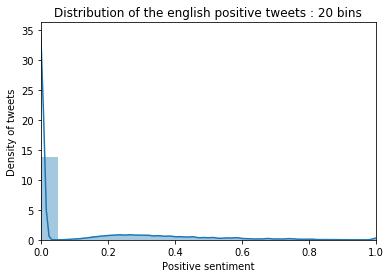

In [24]:
sns.distplot(pos_df_en.select('pos_score').toPandas(),bins=20)
plt.xlim([0,1])
plt.title('Distribution of the english positive tweets : 20 bins')
plt.xlabel('Positive sentiment')
plt.ylabel('Density of tweets')

In [34]:
# Negative analysis
neg_rdd = df_en.rdd.map(lambda r: (r[0],r[2], analyzer.polarity_scores(tweet_cleaner(r[2]))['neg']))
neg_df_en = spark.createDataFrame(neg_rdd, ['tweetid', 'tweet_text', 'neg_score']) # New dataframe
neg_df_en.show()

+------------------+--------------------+---------+
|           tweetid|          tweet_text|neg_score|
+------------------+--------------------+---------+
|567357519547207680|As sun and cloud ...|      0.0|
|493894187079974912|Down in the comfo...|      0.0|
|493688319902220288|Im laughing more ...|      0.0|
|497543470211678209|No, I'm not sayin...|      0.0|
|500956712657223680|Laugh it all off ...|      0.0|
|548763776267218944|It takes courage ...|     0.42|
|577477794218668032|I want to be norm...|      0.0|
|553095178118893568|« Reverie is when...|      0.0|
|873202881222111233|Meet The Democrat...|      0.0|
|874244693307031552|Kellyanne Conway ...|    0.255|
|631377234847248384|RT @e933848ee109a...|      0.0|
|578225585706545152|Some books should...|      0.0|
|653251376760295425|I need this skill...|      0.0|
|834418818659278849|RT @Danimal941: N...|      0.0|
|820207183841337344|RT @MTVNews: SO. ...|    0.474|
|845544366579957760|RT @Real923LA: A ...|      0.0|
|85594033145

Text(0,0.5,'Density of tweets')

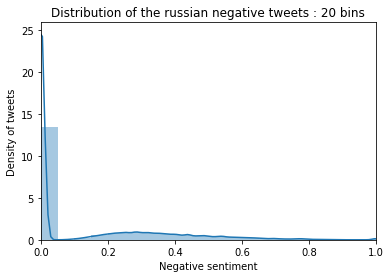

In [28]:
sns.distplot(neg_df_en.select('neg_score').toPandas(),bins=20)
plt.xlim([0,1])
plt.title('Distribution of the russian negative tweets : 20 bins')
plt.xlabel('Negative sentiment')
plt.ylabel('Density of tweets')

Now let us focus, just as before, on the tweets containing Obama and Trump. And perform a positive **and** negative analysis on
both of them.

**Note :** Here we will ignore the scores of 0.0 for plotting visibility 

**Negative Analysis**

In [35]:
# Select the tweets that contain the word Ukrain
neg_df_en.createOrReplaceTempView("neg_en_sql")
query_prediction = """SELECT tweetid, neg_score FROM neg_en_sql WHERE tweet_text LIKE '%Trump%' AND neg_score!=0"""

pred_trump_df = spark.sql(query_prediction)

In [30]:
# Select the tweets that contain the word Russia
query_prediction = """SELECT tweetid, neg_score FROM neg_en_sql WHERE tweet_text LIKE '%Obama%' AND neg_score!=0"""

pred_obama_df = spark.sql(query_prediction)

Text(0,0.5,'Number of tweets')

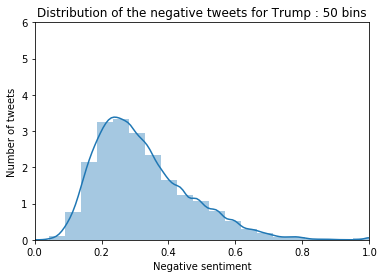

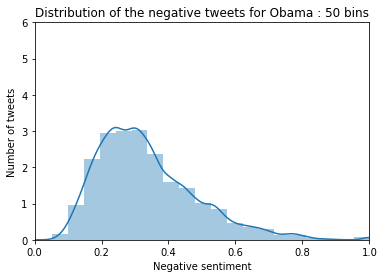

In [31]:
plt.figure(1)
sns.distplot(pred_trump_df.select('neg_score').toPandas(),bins=20)
plt.xlim([0,1])
plt.ylim([0,6])
plt.title('Distribution of the negative tweets for Trump : 20 bins')
plt.xlabel('Negative sentiment')
plt.ylabel('Number of tweets')
plt.figure(2)
sns.distplot(pred_obama_df.select('neg_score').toPandas(),bins=20)
plt.xlim([0,1])
plt.ylim([0,6])
plt.title('Distribution of the negative tweets for Obama : 20 bins')
plt.xlabel('Negative sentiment')
plt.ylabel('Number of tweets')

**Positive analysis**

In [37]:
# Select the tweets that contain the word Ukrain
pos_df_en.createOrReplaceTempView("pos_en_sql")
query_prediction = """SELECT tweetid, pos_score FROM pos_en_sql WHERE tweet_text LIKE '%Trump%' AND pos_score!=0"""

pred_trump_df_2 = spark.sql(query_prediction)

In [33]:
# Select the tweets that contain the word Russia
query_prediction = """SELECT tweetid, pos_score FROM pos_en_sql WHERE tweet_text LIKE '%Obama%' AND pos_score!=0"""

pred_obama_df_2 = spark.sql(query_prediction)

Text(0,0.5,'Number of tweets')

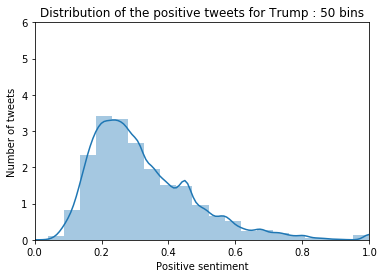

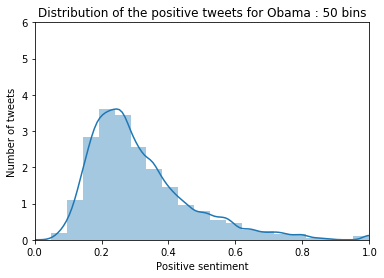

In [34]:
plt.figure(1)
sns.distplot(pred_trump_df_2.select('pos_score').toPandas(),bins=20)
plt.xlim([0,1])
plt.ylim([0,6])
plt.title('Distribution of the positive tweets for Trump : 20 bins')
plt.xlabel('Positive sentiment')
plt.ylabel('Number of tweets')
plt.figure(2)
sns.distplot(pred_obama_df_2.select('pos_score').toPandas(),bins=20)
plt.xlim([0,1])
plt.ylim([0,6])
plt.title('Distribution of the positive tweets for Obama : 20 bins')
plt.xlabel('Positive sentiment')
plt.ylabel('Number of tweets')

@Comment

### Now for the Russian tweets 

In [92]:
# Predict each tweet with the above method
prediction_rdd = translated_ru.rdd.map(lambda r: (r[0],r[1], sentiment_prediction(tweet_cleaner(r[1]))))
prediction_df = spark.createDataFrame(prediction_rdd, ['tweetid', 'tweet_text', 'prediction']) # New dataframe
prediction_df.show()

+------------------+--------------------+----------+
|           tweetid|          tweet_text|prediction|
+------------------+--------------------+----------+
|888352384812019712|Marin Le Pen: We ...|  positive|
|883700663208824832|Elena Prikhodko, ...|  negative|
|838736168640466944|Is Litvinova okay...|   neutral|
|696384621601300480|Ahahaha HTTPS://T...|   neutral|
|884345115363487744|On July 10, 2016 ...|   neutral|
|747049705104891904|"Bobyon is" the "...|   neutral|
|870263243431964672|"Vanichka Nesteru...|   neutral|
|781441079564468224|39-year-old resid...|  negative|
|704991386874019840|Northern Venice ?...|   neutral|
|734372506300256256|Kiev was going to...|   neutral|
|660440831283888128|All those who tod...|  negative|
|757853549615124481|Pushkov called Ru...|  positive|
|805075503329722368|URGENT NEWS! Syri...|   neutral|
|502409560368623617|"Putin saw his ra...|  positive|
|760002770246197248|The Islamic State...|  negative|
|676811008262995969|"This is the" Pin...|   ne

Once again let us look how many tweets are neutral, positive or negative

In [93]:
# Let us see the count of every prediction
prediction_df.createOrReplaceTempView("prediction_sql")

pred_count_df = spark.sql('SELECT prediction, COUNT(tweetid) AS frequency FROM prediction_sql GROUP BY prediction')
pred_count_df.show()

+----------+---------+
|prediction|frequency|
+----------+---------+
|  positive|      693|
|   neutral|     1257|
|  negative|      767|
+----------+---------+



Similarly to the previous analysis, one could be interested about what Russian trolls think of Russia and Ukrain. One could expect that the Ukrain related tweets should be negative as a result of the tensions that exist between both countries. On the other hand, the Russia related tweets are expected to be more positive since they come from supposed nationalist people.

In [94]:
# Count predictions' orentiations for Ukrain tweets
query_prediction = """WITH ukrain_tweet AS (SELECT tweetid, prediction FROM prediction_sql WHERE tweet_text LIKE '%Ukrain%')

SELECT prediction, COUNT(tweetid) AS frequency FROM ukrain_tweet GROUP BY prediction"""

pred_ukrain_count_df = spark.sql(query_prediction)
pred_ukrain_count_pd = pred_ukrain_count_df.toPandas()

In [95]:
# Count predictions' orentiations for Obama tweets
query_prediction = """WITH russia_tweet AS (SELECT tweetid, prediction FROM prediction_sql WHERE tweet_text LIKE '%Russia%')

SELECT prediction, COUNT(tweetid) AS frequency FROM russia_tweet GROUP BY prediction"""

pred_russia_count_df = spark.sql(query_prediction)
pred_russia_count_pd = pred_russia_count_df.toPandas()

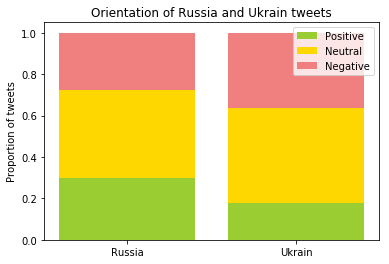

In [96]:
# Plot stacked bars
ind = np.arange(2)
positive_russia = pred_russia_count_pd.loc[pred_russia_count_pd['prediction'] == 'positive']['frequency'].values[0]
neutral_russia = pred_russia_count_pd.loc[pred_russia_count_pd['prediction'] == 'neutral']['frequency'].values[0]
negative_russia = pred_russia_count_pd.loc[pred_russia_count_pd['prediction'] == 'negative']['frequency'].values[0]
total = positive_russia + neutral_russia + negative_russia
positive_russia /= total
neutral_russia /= total
negative_russia /= total

positive_ukrain = pred_ukrain_count_pd.loc[pred_ukrain_count_pd['prediction'] == 'positive']['frequency'].values[0]
neutral_ukrain = pred_ukrain_count_pd.loc[pred_ukrain_count_pd['prediction'] == 'neutral']['frequency'].values[0]
negative_ukrain = pred_ukrain_count_pd.loc[pred_ukrain_count_pd['prediction'] == 'negative']['frequency'].values[0]
total = positive_ukrain + neutral_ukrain + negative_ukrain
positive_ukrain /= total
neutral_ukrain /= total
negative_ukrain /= total

positives = [positive_russia, positive_ukrain]
neutrals = [neutral_russia, neutral_ukrain]
negatives = [negative_russia, negative_ukrain]

p1 = plt.bar(ind, positives, color='yellowgreen')
p2 = plt.bar(ind, neutrals, color='gold', bottom = positives)
p3 = plt.bar(ind, negatives, color='lightcoral', bottom = [x+y for x,y in zip(neutrals, positives)])

plt.ylabel('Proportion of tweets')
plt.title('Orientation of Russia and Ukrain tweets')
plt.xticks(ind, ('Russia', 'Ukrain'))
plt.legend((p1[0], p2[0], p3[0]), ('Positive', 'Neutral', 'Negative'))

The results are exactly the one expected, the Ukrain related tweets tend to be **much** more negative that those about Russia. The opposite holds for the positive tweets as well. 

#### Further analysis

Let us now perform the same analysis as above but this time with a higher level sentiment analyser

In [15]:
# Positive analysis
pos_rdd = translated_ru.rdd.map(lambda r: (r[0],r[1], float(analyzer.polarity_scores(tweet_cleaner(r[1]))['pos'])))
pos_df = spark.createDataFrame(pos_rdd, ['tweetid', 'tweet_text', 'pos_score']) # New dataframe

Text(0,0.5,'Density of tweets')

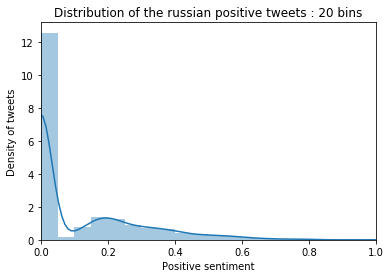

In [16]:
sns.distplot(pos_df.select('pos_score').toPandas(),bins=20)
plt.xlim([0,1])
plt.title('Distribution of the russian positive tweets : 20 bins')
plt.xlabel('Positive sentiment')
plt.ylabel('Density of tweets')

Same procedure now for the negative sentiment

In [17]:
# Negative analysis
neg_rdd = translated_ru.rdd.map(lambda r: (r[0],r[1], analyzer.polarity_scores(tweet_cleaner(r[1]))['neg']))
neg_df = spark.createDataFrame(neg_rdd, ['tweetid', 'tweet_text', 'neg_score']) # New dataframe
neg_df.show()

+------------------+--------------------+---------+
|           tweetid|          tweet_text|neg_score|
+------------------+--------------------+---------+
|888352384812019712|Marin Le Pen: We ...|      0.0|
|883700663208824832|Elena Prikhodko, ...|    0.187|
|838736168640466944|Is Litvinova okay...|      0.0|
|696384621601300480|Ahahaha HTTPS://T...|      0.0|
|884345115363487744|On July 10, 2016 ...|    0.272|
|747049705104891904|"Bobyon is" the "...|      0.0|
|870263243431964672|"Vanichka Nesteru...|      0.0|
|781441079564468224|39-year-old resid...|      0.0|
|704991386874019840|Northern Venice ?...|      0.0|
|734372506300256256|Kiev was going to...|      0.0|
|660440831283888128|All those who tod...|    0.398|
|757853549615124481|Pushkov called Ru...|      0.0|
|805075503329722368|URGENT NEWS! Syri...|      0.0|
|502409560368623617|"Putin saw his ra...|      0.0|
|760002770246197248|The Islamic State...|      0.0|
|676811008262995969|"This is the" Pin...|      0.0|
|73181971558

Text(0,0.5,'Density of tweets')

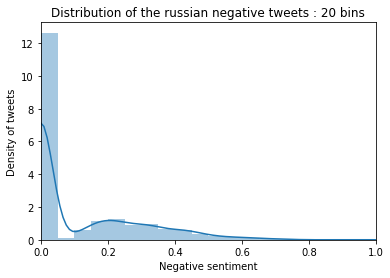

In [18]:
sns.distplot(neg_df.select('neg_score').toPandas(),bins=20)
plt.xlim([0,1])
plt.title('Distribution of the russian negative tweets : 20 bins')
plt.xlabel('Negative sentiment')
plt.ylabel('Density of tweets')

Let us now compare once again the negativity distribution of the tweets talking about Russia and Ukrain.

**Note :** Here we will ignore the scores of 0.0 for plotting visibility 

In [101]:
# Select the tweets that contain the word Ukrain
neg_df.createOrReplaceTempView("neg_sql")
query_prediction = """SELECT tweetid, neg_score FROM neg_sql WHERE tweet_text LIKE '%Ukrain%' AND neg_score!=0"""

pred_ukrain_count_df = spark.sql(query_prediction)

In [102]:
# Select the tweets that contain the word Russia
query_prediction = """SELECT tweetid, neg_score FROM neg_sql WHERE tweet_text LIKE '%Russia%' AND neg_score!=0"""

pred_russia_count_df = spark.sql(query_prediction)

Text(0,0.5,'Number of sentences')

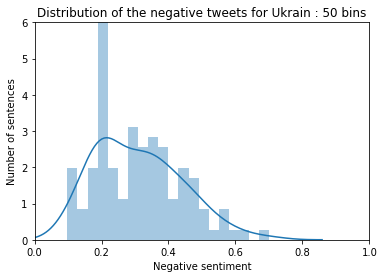

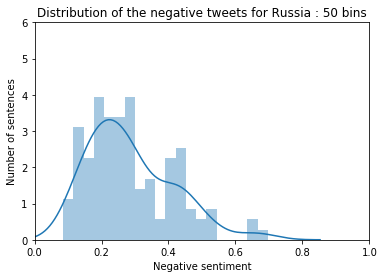

In [103]:
plt.figure(1)
sns.distplot(pred_ukrain_count_df.select('neg_score').toPandas(),bins=20)
plt.xlim([0,1])
plt.ylim([0,6])
plt.title('Distribution of the negative tweets for Ukrain : 50 bins')
plt.xlabel('Negative sentiment')
plt.ylabel('Number of sentences')
plt.figure(2)
sns.distplot(pred_russia_count_df.select('neg_score').toPandas(),bins=20)
plt.xlim([0,1])
plt.ylim([0,6])
plt.title('Distribution of the negative tweets for Russia : 50 bins')
plt.xlabel('Negative sentiment')
plt.ylabel('Number of sentences')

@Comment

### Saving it all
Now that the sentiment analysis has been made, we can save positive and negative for both the naive and vaderAnalyser methods, as they will be needed for studying their impacts on popularity

In [25]:
# All Trump tweets
trump_query = """SELECT tweetid, prediction FROM prediction_sql WHERE tweet_text LIKE '%Trump%'"""

trump_df = spark.sql(trump_query)
trump_df.createOrReplaceTempView("trump_sql")

In [ ]:
# Save all tweets related to Trump
trump_df.write.mode('overwrite').parquet("trump_tweets")

In [26]:
# Save positives and negative naive Trump tweets into parquets
pos_query = """SELECT tweetid FROM trump_sql WHERE prediction LIKE '%positive%'"""
neg_query = """SELECT tweetid FROM trump_sql WHERE prediction LIKE '%negative%'"""

spark.sql(pos_query).write.mode('overwrite').parquet("pos_trump_naive")
spark.sql(neg_query).write.mode('overwrite').parquet("neg_trump_naive")

In [27]:
# All Obama tweets
obama_query = """SELECT tweetid, prediction FROM prediction_sql WHERE tweet_text LIKE '%Obama%'"""

obama_df = spark.sql(obama_query)
obama_df.createOrReplaceTempView("obama_sql")

In [ ]:
# Save all tweets related to Obama
obama_df.write.mode('overwrite').parquet("obama_tweets")

In [28]:
# Save positives and negative naive Obama tweets into parquets
pos_query = """SELECT tweetid FROM obama_sql WHERE prediction LIKE '%positive%'"""
neg_query = """SELECT tweetid FROM obama_sql WHERE prediction LIKE '%negative%'"""

spark.sql(pos_query).write.mode('overwrite').parquet("pos_obama_naive")
spark.sql(neg_query).write.mode('overwrite').parquet("neg_obama_naive")

In [38]:
# Save positives and negative vader Trump tweets into parquets
pos_query = """SELECT tweetid FROM pos_en_sql WHERE pos_score > 0.5 AND tweet_text LIKE '%Trump%'"""
neg_query = """SELECT tweetid FROM neg_en_sql WHERE neg_score > 0.5 AND tweet_text LIKE '%Trump%'"""

spark.sql(pos_query).write.mode('overwrite').parquet("pos_trump_vader")
spark.sql(neg_query).write.mode('overwrite').parquet("neg_trump_vader")

In [39]:
# Save positives and negative vader Trump tweets into parquets
pos_query = """SELECT tweetid FROM pos_en_sql WHERE pos_score > 0.5 AND tweet_text LIKE '%Obama%'"""
neg_query = """SELECT tweetid FROM neg_en_sql WHERE neg_score > 0.5 AND tweet_text LIKE '%Obama%'"""

spark.sql(pos_query).write.mode('overwrite').parquet("pos_obama_vader")
spark.sql(neg_query).write.mode('overwrite').parquet("neg_obama_vader")

## Links in Tweets

We now take a closer look at the urls that can be found in the troll tweets.
We first need to gather all those urls.

In [37]:
tweets_stats_df['tweetid','urls'].createOrReplaceTempView("urls_sql")
urls_pd = spark.sql("SELECT urls FROM urls_sql WHERE urls IS NOT NULL AND NOT urls='[]'").toPandas()

In [38]:
# Extract urls from the string present in the column
urls_array_list = urls_pd['urls'].apply(lambda x : x[1:-1].split(", "))

In [39]:
urls_list = [item for sublist in urls_array_list for item in sublist]
print(len(urls_array_list))
print(len(urls_list))

4590337
4635677


#### Popular URLs
We can now proceed to count the occurences of specific urls to discover which ones are popular.

In [40]:
all_urls = {}
for u in urls_list:
    if u in all_urls:
        all_urls[u] += 1
    else:
        all_urls[u] = 1
sorted_urls = sorted(all_urls, key=all_urls.get, reverse=True)

In [41]:
urls_df = pd.DataFrame()
urls_df['url'] = sorted_urls
urls_df['count'] = urls_df['url'].map(lambda x: all_urls[x])
print(urls_df.shape)
urls_df.head(10)

(2776243, 2)


,url,count
0,http://1063.mobi,4428
1,http://USFREEDOMARMY.COM,3662
2,http://kiev-news.com/13876-detskaya-bolnica-v-...,2867
3,http://kievsmi.net/novosti/politics/47097-klim...,2801
4,http://bit.ly/1D3LvAc,2369
5,http://kiev-news.com/13872-v-kieve-shkolnikov-...,2178
6,http://Covfefe.bz,2054
7,https://twibble.io,1889
8,http://www.theunder.us,1317
9,http://riafan.ru/119118-nigeriya-zaklyuchila-s...,1284


In [42]:
urls_df.describe()

,count
count,2.776243e+06
mean,1.669766e+00
std,6.886708e+00
min,1.000000e+00
25%,1.000000e+00
50%,1.000000e+00
75%,1.000000e+00
max,4.428000e+03


From the statistics obtained thanks to *describe*, we can see that the vast majority of urls only appear once. But some of them seem strangely popular. Those are mostly domain names, and not specific pages. In the top 10 we find:

* **http://USFREEDOMARMY.COM**, **http://Covfefe.bz**, **https://www.telegraph.co.uk**: those three are linked to American politics. The first one is a right-wing fake news website. The second one gets its name from a famous Trump tweet. The last one is a British newspaper which has a notable conservative stance and  which has been [accused of spreading pro-Russian propaganda](https://en.wikipedia.org/wiki/The_Daily_Telegraph#Accusation_of_news_coverage_influence_by_advertisers).
(**NB**: *http://bit.ly/1D3LvAc* is a shortened url for *https://www.telegraph.co.uk*.)

* Several (supposedly) Ukrainian articles written in Russian.

* **https://twibble.io**: a social media manager.

* **http://1063.mobi**, **http://www.theunder.us**: two indie web radios.

We were intrigued by *http://1063.mobi* and its particularly high count, so we decided to investigate further. The url redirects to *http://1063atl.com*, an Atlanta based indie web radio. As this is not exactly the same url, we wanted to make sure that *1063atl.com* is effectively the new name of *1063.mobi*, and not something completely different.

Using the [Wayback Machine](http://web.archive.org), we are able to take a look at the website before the redirection existed. [This](http://web.archive.org/web/20180110013854/http://1063.mobi:80/) shows us that the page was indeed very similar to the current *http://1063atl.com*.

We are also interested in knowing the context in which this url was used.

In [43]:
urls_1063mobi_df = spark.sql("SELECT tweetid, urls FROM urls_sql WHERE urls LIKE '%http://1063.mobi%'")
tweets_text_df.createOrReplaceTempView("tweets_text_sql")
text_1063mobi_df = spark.sql("SELECT tweet_text FROM tweets_text_sql T, urls_sql U WHERE urls LIKE '%http://1063.mobi%' AND T.tweetid=U.tweetid")

In [44]:
for x in (text_1063mobi_df.select('tweet_text').toPandas())['tweet_text'][0:20]:
    print(x)

RT @IndieRadioPlay: Now Playing: Kyeza Gattsbee - Victory (@KyeGattsbee) -&gt; https://t.co/eMX9JgTv3v
RT @IndieRadioPlay: Now Playing: The Way - We Live ft. Audio Push -&gt; https://t.co/eMX9JgTv3v
RT @IndieRadioPlay: Now Playing: Cam247 (@robbie_mosely) - I Am Hooked -&gt; https://t.co/eMX9JgTv3v
RT @IndieRadioPlay: Now Playing: Monty - Right Back feat. Fetty Wap -&gt; https://t.co/eMX9JgTv3v
RT @IndieRadioPlay: Now Playing: Plies - Mad At Myself -&gt; https://t.co/eMX9JgTv3v
RT @IndieRadioPlay: Now Playing: Rich The Kid - That Bag Remix ft. Lil Durk -&gt; https://t.co/eMX9JgTv3v
RT @IndieRadioPlay: Now Playing: Nipsey Hussle - State of Mind ft. Y2 -&gt; https://t.co/eMX9JgTv3v
RT @IndieRadioPlay: Now Playing: RickStarr (@SlickRickstarr) - Real Talk ft. SuperNard (@apgsupernard) -&gt; https://t.co/eMX9JgTv3v
RT @IndieRadioPlay: Now Playing: Blac Youngsta Ft.Young Thug - Youngsta -&gt; https://t.co/eMX9JgTv3v
RT @IndieRadioPlay: Now Playing: DeJ Loaf - Beef N Broccoli -&gt; https://t.

All those tweets seem mostly inoffensive, although they could be considered as spam. But they are all directed towards two Twitter handles: **@IndieRadioPlay** and **@1063atl**.
A quick look on Twitter shows us that **@IndieRadioPlay** does not exist anymore. Once again, with the Wayback Machine, we can get an idea of [what the page looked like](http://web.archive.org/web/20150822213646/https://twitter.com/indieradioplay). 

This account has the same banner and the same creation date as the [current Twitter page](https://twitter.com/1063atl?lang=fr) *@1063atl*. We can thus suppose that they are the same.

It is interesting to see that the most used url does not seem to be related to politics at all. Further investigations are necessary to understand why: is it an attempt to look like a normal user and/or to boost a troll account's statistics/popularity? Is there a reason for this radio to be targetted by the trolls or are they completely unrelated (outside of those tweets)?

#### Popular domains
After looking at specific urls, we observe the most popular domain names.

In [45]:
domains = {}
for u in urls_list:
    dom = urlparse(u).netloc
    if dom in domains:
        domains[dom] += 1
    else:
        domains[dom] = 1
sorted_domains = sorted(domains, key=domains.get, reverse=True)

In [46]:
domains_df = pd.DataFrame()
domains_df['domain'] = sorted_domains
domains_df['count'] = domains_df['domain'].map(lambda x: domains[x])
print(domains_df.shape)
domains_df.head(10)

(34941, 2)


,domain,count
0,bit.ly,975028
1,riafan.ru,428794
2,twitter.com,225851
3,ift.tt,168894
4,goo.gl,156294
5,dlvr.it,141687
6,www.gazeta.ru,123032
7,j.mp,105545
8,russian.rt.com,73069
9,youtu.be,61135


In [47]:
domains_df.describe()

,count
count,34941.000000
mean,132.671561
std,6145.051994
min,1.000000
25%,1.000000
50%,2.000000
75%,7.000000
max,975028.000000


As expected, there are much less unique domain names than urls. Again, most of them are used only once or twice. But some of them have a count that contrasts with the rest.

In the top 10, we have:
* **bit.ly**, **goo.gl**, **j.mp**: url shorteners, which are very practical for tweets since the number of characters is limited. Sadly, they do not teach us anything about their content: to know more about that, we need to open them and see where they redirect.
* **rufian.ru**, **gazeta.ru**, **russian.rt.com**: Russian news websites.
* **ift.tt**, **dlvr.it**: social media management systems.
* **youtu.be**: shorter url for Youtube.
* **twitter.com**: many urls on Twitter refer to the website itself. The shortener **t.co** is also very popular.

#### Conclusion

We can easily get a lot of info on the hyperlinks used by the trolls. Several built-in functions, such as *urlparse()* or *requests.get()*, can be used to obtain what we need. For the next step, it would be interesting to find an efficient way to expand the shortened url (their number is so high that applying *requests.get()* is very slow). 

In [49]:
def expandUrl(u):
    try:
        return unshortener.unshorten(u)
    except:
        return u

In [ ]:
expanded_urls = []
unshortener = UnshortenIt()
for u in sorted_urls:
    exp_u = expandUrl(u)
    expanded_urls.append(exp_u)